# Прогнозирование цены биткоина

Обучающие данные - это ежедневные данные о цене биткоина за предыдущие полтора года.

Тестовые данные - 7 дней после окончания обучающих данных.

Установим библиотеку CatBoost

Отключим вывод предупреждений

In [1]:
import warnings
warnings.filterwarnings('ignore')

Импортируем необходимые библиотеки

In [2]:
# библиотеки для обработки и анализа структурированных данных
import pandas as pd
import numpy as np

# библиотеки визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# библиотека статистических моделей
from statsmodels.tsa.seasonal import seasonal_decompose

# библиотека для машинного обучения на основе градиентного бустинга
from catboost import CatBoostRegressor

# библиотека моделей для машинного обучения
from sklearn.metrics import mean_absolute_error

Настройки визуализации

In [3]:
sns.set_theme()

FONT_SMALL_SIZE = 10
FONT_MEDIUM_SIZE = 12
FONT_BIGGER_SIZE = 15

plt.rc('font', size=FONT_SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=FONT_MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=1)                  # line width
plt.rc('figure', figsize=(12, 4))             # size of the figure

## Формирование датасета

*последние 7 строк для теста содержат значения, скопированные с предыдущего дня*

Сформируем рабочий датасет

In [4]:
file_path = r'D:\__projects__\diploma\portfolios-optimization\data\BTCUSDT_hourly_data.csv'

df = pd.read_csv(
    file_path,
    parse_dates=['Open time'], 
    index_col='Open time'   
)

data = df.copy()

print('Total length:', len(data))

data = data.sort_index()

columns_to_keep_and_rename = {
    'Open': 'Open',
    'High': 'High',
    'Low': 'Low',
    'Close': 'Price',
    'Volume': 'Vol.' 
}

data = data[list(columns_to_keep_and_rename.keys())]
data = data.rename(columns=columns_to_keep_and_rename)

data['Change %'] = data['Price'].pct_change() * 100
data['Change %'] = data['Change %'].map('{:.2f}%'.format)

display(data.head())

print("\nТипы данных в колонках:")
print(data.dtypes)

# И информацию о датафрейме
print("\nИнформация о датафрейме:")
data.info()

Total length: 37996


,Open,High,Low,Price,Vol.,Change %
Open time,,,,,,
2021-01-01 00:00:00,28923.63,29031.34,28690.17,28995.13,2311.811445,nan%
2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,5403.068471,1.43%
2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,2384.231560,-0.73%
2021-01-01 03:00:00,29195.25,29367.00,29150.02,29278.40,1461.345077,0.29%
2021-01-01 04:00:00,29278.41,29395.00,29029.40,29220.31,2038.046803,-0.20%



Типы данных в колонках:
Open        float64
High        float64
Low         float64
Price       float64
Vol.        float64
Change %     object
dtype: object

Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37996 entries, 2021-01-01 00:00:00 to 2025-05-03 16:00:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      37996 non-null  float64
 1   High      37996 non-null  float64
 2   Low       37996 non-null  float64
 3   Price     37996 non-null  float64
 4   Vol.      37996 non-null  float64
 5   Change %  37996 non-null  object 
dtypes: float64(5), object(1)
memory usage: 2.0+ MB


Преобразуем значения столбцов в нужный формат

In [5]:
data['Change %'] = data['Change %'].apply(lambda x: float(x.replace('%', '')))

# Удаляем колонку 'Vol.', если она больше не нужна.
data = data.drop('Vol.', axis=1)

# Для проверки можно вывести типы данных и первые строки
print("\nТипы данных после изменений во второй ячейке:")
print(data.dtypes)
print("\nПервые 5 строк после изменений во второй ячейке:")
from IPython.display import display # Убедись, что display импортирован, если запускаешь в Jupyter
display(data.head())


Типы данных после изменений во второй ячейке:
Open        float64
High        float64
Low         float64
Price       float64
Change %    float64
dtype: object

Первые 5 строк после изменений во второй ячейке:


,Open,High,Low,Price,Change %
Open time,,,,,
2021-01-01 00:00:00,28923.63,29031.34,28690.17,28995.13,NaN
2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,1.43
2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,-0.73
2021-01-01 03:00:00,29195.25,29367.00,29150.02,29278.40,0.29
2021-01-01 04:00:00,29278.41,29395.00,29029.40,29220.31,-0.20


In [6]:
import pandas as pd
import json # Для обработки JSON-подобных строк

# Загрузка новостного датасета
news_file_path = r'D:\__projects__\diploma\portfolios-optimization\notebooks\news_data\btc\combined_btc_news.csv'
try:
    news_df = pd.read_csv(news_file_path)
except FileNotFoundError:
    print(f"Файл новостей не найден: {news_file_path}")
    # Реши, как обрабатывать эту ситуацию: остановить выполнение или продолжить без новостей
    news_df = pd.DataFrame() # Пустой DataFrame, чтобы код ниже не падал сразу

if not news_df.empty:
    # Преобразуем 'date_published' в datetime
    news_df['date_published'] = pd.to_datetime(news_df['date_published'])
    
    # Установим 'date_published' как индекс
    news_df.set_index('date_published', inplace=True)
    
    # Отсортируем по индексу (важно для дальнейших операций resample/rolling)
    news_df.sort_index(inplace=True)

    print("Новостной датасет загружен и базово обработан:")
    display(news_df.head(2))
    print(news_df.info())
else:
    print("Новостной датасет пуст или не загружен.")

Новостной датасет загружен и базово обработан:


,title,url,authors,summary,banner_image,source,category_within_source,source_domain,topics,overall_sentiment_score,overall_sentiment_label,ticker_sentiment
date_published,,,,,,,,,,,,
2022-03-01 12:58:36,Geopolitical Risk Returns for Global Markets,https://www.nytimes.com/2022/03/01/business/de...,[],Investors are weighing the implications of Rus...,https://static01.nyt.com/images/2022/03/01/mul...,New York Times,Dealbook,www.nytimes.com,"[{'topic': 'Economy - Monetary', 'relevance_sc...",-0.138797,Neutral,"[{'ticker': 'NFLX', 'relevance_score': '0.0189..."
2022-03-02 02:32:56,"Asian shares slip, oil surges again as Russia ...",https://www.moneycontrol.com/news/business/mar...,[],"As global sanctions against Moscow tighten, th...",https://images.moneycontrol.com/static-mcnews/...,Money Control,Markets,www.moneycontrol.com,"[{'topic': 'Energy & Transportation', 'relevan...",-0.031243,Neutral,"[{'ticker': 'EQNR', 'relevance_score': '0.0639..."


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63355 entries, 2022-03-01 12:58:36 to 2025-05-02 05:57:38
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    63355 non-null  object 
 1   url                      63355 non-null  object 
 2   authors                  63355 non-null  object 
 3   summary                  63353 non-null  object 
 4   banner_image             60670 non-null  object 
 5   source                   63355 non-null  object 
 6   category_within_source   27173 non-null  object 
 7   source_domain            63355 non-null  object 
 8   topics                   63355 non-null  object 
 9   overall_sentiment_score  63355 non-null  float64
 10  overall_sentiment_label  63355 non-null  object 
 11  ticker_sentiment         63355 non-null  object 
dtypes: float64(1), object(11)
memory usage: 6.3+ MB
None


In [7]:
def extract_btc_sentiment(ticker_sentiment_str):
    if pd.isna(ticker_sentiment_str):
        return None
    try:
        # Строка может быть обернута в одинарные кавычки, json.loads ожидает двойные
        # Также уберем возможные проблемы с None/True/False, если они не стандартные JSON
        processed_str = ticker_sentiment_str.replace("'", '"')
        # json.loads может не справиться с некоторыми форматами, eval более гибкий, но менее безопасный
        # Если уверены в источнике, можно использовать eval, но с осторожностью.
        # Для AlphaVantage, если это действительно список словарей, json.loads должен работать
        # после замены кавычек.
        
        # Более безопасный способ, если json.loads не работает напрямую
        # из-за формата, похожего на Python-список, а не строгий JSON:
        import ast
        tickers_list = ast.literal_eval(ticker_sentiment_str) # Используем ast.literal_eval для безопасности
        
        for ticker_info in tickers_list:
            if ticker_info.get('ticker') == 'CRYPTO:BTC':
                return float(ticker_info.get('ticker_sentiment_score', 0.0)) # Возвращаем 0.0 если нет score
        return None # BTC не найден в списке
    except (SyntaxError, ValueError, TypeError) as e:
        # print(f"Ошибка парсинга ticker_sentiment: {e} для строки: {ticker_sentiment_str[:100]}")
        return None # В случае ошибки парсинга

if not news_df.empty:
    news_df['btc_specific_sentiment'] = news_df['ticker_sentiment'].apply(extract_btc_sentiment)
    print("\nНовостной датасет с извлеченным BTC сентиментом:")
    display(news_df[['overall_sentiment_score', 'btc_specific_sentiment']].head())
    print(f"Количество новостей с BTC сентиментом: {news_df['btc_specific_sentiment'].notna().sum()} из {len(news_df)}")


Новостной датасет с извлеченным BTC сентиментом:


,overall_sentiment_score,btc_specific_sentiment
date_published,,
2022-03-01 12:58:36,-0.138797,-0.118125
2022-03-02 02:32:56,-0.031243,0.006883
2022-03-02 08:00:00,-0.174572,-0.009523
2022-03-02 10:00:25,-0.036470,0.001776
2022-03-02 11:00:26,0.034280,-0.052478


Количество новостей с BTC сентиментом: 63355 из 63355


In [8]:
if not news_df.empty:
    # Выбираем нужные числовые колонки для агрегации
    cols_to_aggregate = ['overall_sentiment_score', 'btc_specific_sentiment']
    
    # Создаем признак "количество новостей"
    news_df['news_count'] = 1 
    
    # Агрегируем до часовой частоты
    # .resample('H') - группирует по часам
    # .agg() - применяет функции агрегации
    hourly_news_aggregated = news_df.resample('H').agg(
        avg_overall_sentiment=('overall_sentiment_score', 'mean'),
        avg_btc_specific_sentiment=('btc_specific_sentiment', 'mean'),
        sum_news_count=('news_count', 'sum')
        # Можно добавить другие агрегации, например, min, max, std для сентимента
    )
    
    # Заполним NaN, которые появятся в часах без новостей.
    # Можно заполнить нулями (означает отсутствие новостей / нейтральный сентимент)
    # или использовать ffill/bfill, если это имеет смысл.
    hourly_news_aggregated.fillna(0, inplace=True) # Заполняем нулями, т.к. нет новостей = нет влияния/нейтрально
                                                 # Для sum_news_count 0 - логично.
                                                 # Для avg_sentiment 0 может означать нейтрально.

    print("\nАгрегированные часовые новостные данные:")
    display(hourly_news_aggregated.head())
else:
    hourly_news_aggregated = pd.DataFrame() # Пустой, если новостей не было


Агрегированные часовые новостные данные:


,avg_overall_sentiment,avg_btc_specific_sentiment,sum_news_count
date_published,,,
2022-03-01 12:00:00,-0.138797,-0.118125,1
2022-03-01 13:00:00,0.000000,0.000000,0
2022-03-01 14:00:00,0.000000,0.000000,0
2022-03-01 15:00:00,0.000000,0.000000,0
2022-03-01 16:00:00,0.000000,0.000000,0


In [9]:
# Убедимся, что индекс 'data' тоже DatetimeIndex
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data.index)

if not hourly_news_aggregated.empty:
    # Объединяем, используя левое соединение, чтобы сохранить все строки из 'data'
    data_with_news = data.merge(hourly_news_aggregated, left_index=True, right_index=True, how='left')
    
    # После merge, для часов в 'data', где не было соответствующих новостей в 'hourly_news_aggregated',
    # появятся NaN. Заполним их нулями (или другим подходящим значением).
    news_cols_in_merged = list(hourly_news_aggregated.columns)
    data_with_news[news_cols_in_merged] = data_with_news[news_cols_in_merged].fillna(0)
    
    print("\nФинальный датасет 'data_with_news' (первые строки):")
    display(data_with_news.head())
    print("\nХвостовые строки, чтобы проверить заполнение NaN:")
    display(data_with_news.tail())
    print(data_with_news.info())
else:
    print("Новостные данные не были добавлены, так как 'hourly_news_aggregated' пуст.")
    data_with_news = data.copy() # Работаем с исходными данными, если новостей нет

# Теперь data_with_news содержит исходные данные BTC и добавленные часовые новостные признаки.
# Этот data_with_news можно использовать для дальнейшей предобработки и обучения модели.


Финальный датасет 'data_with_news' (первые строки):


,Open,High,Low,Price,Change %,avg_overall_sentiment,avg_btc_specific_sentiment,sum_news_count
2021-01-01 00:00:00,28923.63,29031.34,28690.17,28995.13,NaN,0.0,0.0,0.0
2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,1.43,0.0,0.0,0.0
2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,-0.73,0.0,0.0,0.0
2021-01-01 03:00:00,29195.25,29367.00,29150.02,29278.40,0.29,0.0,0.0,0.0
2021-01-01 04:00:00,29278.41,29395.00,29029.40,29220.31,-0.20,0.0,0.0,0.0



Хвостовые строки, чтобы проверить заполнение NaN:


,Open,High,Low,Price,Change %,avg_overall_sentiment,avg_btc_specific_sentiment,sum_news_count
2025-05-03 13:00:00,96120.43,96330.00,96106.53,96330.00,0.22,0.0,0.0,0.0
2025-05-03 14:00:00,96329.99,96459.67,96292.63,96380.95,0.05,0.0,0.0,0.0
2025-05-03 15:00:00,96380.96,96509.44,96380.95,96390.32,0.01,0.0,0.0,0.0
2025-05-03 16:00:00,96418.68,96428.33,96330.50,96364.82,-0.03,0.0,0.0,0.0
2025-05-03 16:00:00,96418.68,96428.33,96330.50,96330.52,-0.04,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37996 entries, 2021-01-01 00:00:00 to 2025-05-03 16:00:00
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Open                        37996 non-null  float64
 1   High                        37996 non-null  float64
 2   Low                         37996 non-null  float64
 3   Price                       37996 non-null  float64
 4   Change %                    37995 non-null  float64
 5   avg_overall_sentiment       37996 non-null  float64
 6   avg_btc_specific_sentiment  37996 non-null  float64
 7   sum_news_count              37996 non-null  float64
dtypes: float64(8)
memory usage: 2.6 MB
None


In [10]:
data = data_with_news.copy()

In [11]:
data

,Open,High,Low,Price,Change %,avg_overall_sentiment,avg_btc_specific_sentiment,sum_news_count
2021-01-01 00:00:00,28923.63,29031.34,28690.17,28995.13,NaN,0.0,0.0,0.0
2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,1.43,0.0,0.0,0.0
2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,-0.73,0.0,0.0,0.0
2021-01-01 03:00:00,29195.25,29367.00,29150.02,29278.40,0.29,0.0,0.0,0.0
2021-01-01 04:00:00,29278.41,29395.00,29029.40,29220.31,-0.20,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2025-05-03 13:00:00,96120.43,96330.00,96106.53,96330.00,0.22,0.0,0.0,0.0
2025-05-03 14:00:00,96329.99,96459.67,96292.63,96380.95,0.05,0.0,0.0,0.0
2025-05-03 15:00:00,96380.96,96509.44,96380.95,96390.32,0.01,0.0,0.0,0.0
2025-05-03 16:00:00,96418.68,96428.33,96330.50,96364.82,-0.03,0.0,0.0,0.0


Установим константы

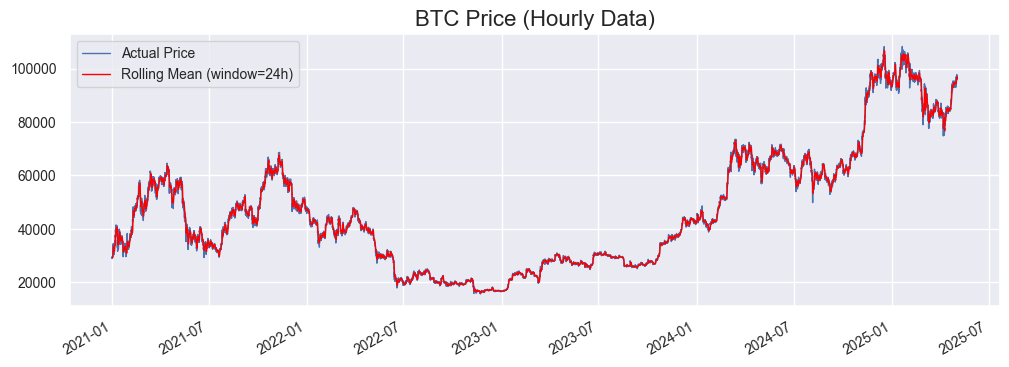

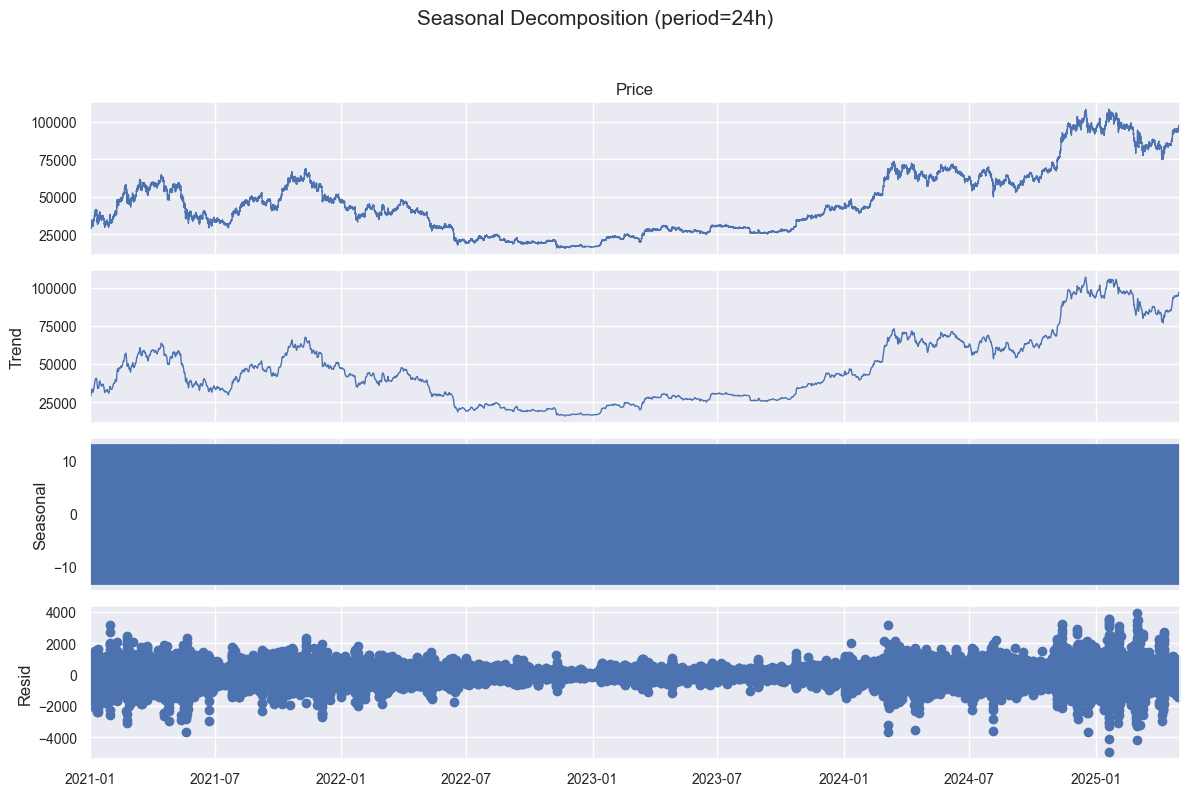

Размер обучающей выборки (data_train): 37828 наблюдений
Размер тестовой выборки (data_test): 168 наблюдений (7 дней)


In [12]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd # Убедись, что pandas импортирован, если он используется для data

# Предполагаем, что 'data' и 'TARGET' уже определены из предыдущих ячеек
TARGET = 'Price' # уже должно быть определено

# --- Корректировки для часовых данных и 7-дневного прогноза ---
HOURS_IN_DAY = 24
DAYS_FOR_TEST = 7
TEST_SIZE = DAYS_FOR_TEST * HOURS_IN_DAY # 7 дней * 24 часа = 168 часов

# --- Параметры, которые были в твоем коде ---
RANDOM_SEED = 0 # параметр рандомизации
FOLDS_N = 10 # количество фолдов

# Обучающая выборка (все данные, кроме последних TEST_SIZE часов)
data_train = data[:-TEST_SIZE] # Переименовал в data_train для ясности
# Тестовая выборка (последние TEST_SIZE часов)
data_test = data[-TEST_SIZE:]

# --- Визуализация ---
# Предположим, FONT_BIGGER_SIZE определен где-то ранее,
# если нет, замени на число или удали параметр fontsize
FONT_BIGGER_SIZE = 16 # Пример значения, если не определено

plt.rc('figure', figsize=(12, 4))
plt.title(f'BTC {TARGET} (Hourly Data)', fontsize=FONT_BIGGER_SIZE)
data[TARGET].plot(label='Actual Price')

# Скользящее среднее:
# window=60 (2.5 дня) было в оригинале.
# Предлагаю рассмотреть window=24 (дневное) или window=168 (недельное) для часовых данных.
# Оставим 60, если это специфический выбор, но укажем альтернативы.
rolling_window_hourly = 24 * 1 # Например, за 1 день (24 часа). Можно изменить на 60, если это важно.
# rolling_window_hourly = 60 # Твой оригинальный выбор
# rolling_window_hourly = 24*7 # Недельное сглаживание

r = data[TARGET].rolling(window=rolling_window_hourly)
rolling_mean = r.mean()
rolling_mean.plot(color='red', label=f'Rolling Mean (window={rolling_window_hourly}h)')
plt.legend()
plt.show()

# Сезонная декомпозиция:
# period=60 (2.5 дня) был в оригинале.
# Для часовых данных более типичны period=24 (дневная сезонность) или period=168 (недельная).
# Рекомендую начать с дневной сезонности.
decomposition_period_hourly = 24 # Дневная сезонность (24 часа)
# decomposition_period_hourly = 24*7 # Недельная сезонность (168 часов)
# decomposition_period_hourly = 60 # Твой оригинальный выбор

# Убедимся, что в данных достаточно периодов для декомпозиции
if len(data[TARGET]) >= 2 * decomposition_period_hourly:
    sd = seasonal_decompose(data[TARGET], period=decomposition_period_hourly, model='additive')
    plt.rc('figure', figsize=(12, 8)) # Увеличил немного высоту для лучшей читаемости 3х графиков
    sd.plot()
    plt.suptitle(f'Seasonal Decomposition (period={decomposition_period_hourly}h)', y=0.99) # Добавил общий заголовок
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Чтобы suptitle не накладывался
else:
    print(f"Недостаточно данных для сезонной декомпозиции с периодом {decomposition_period_hourly}.")
    print(f"Требуется как минимум {2 * decomposition_period_hourly} точек, в наличии {len(data[TARGET])}.")

plt.show()

print(f"Размер обучающей выборки (data_train): {len(data_train)} наблюдений")
print(f"Размер тестовой выборки (data_test): {len(data_test)} наблюдений ({DAYS_FOR_TEST} дней)")

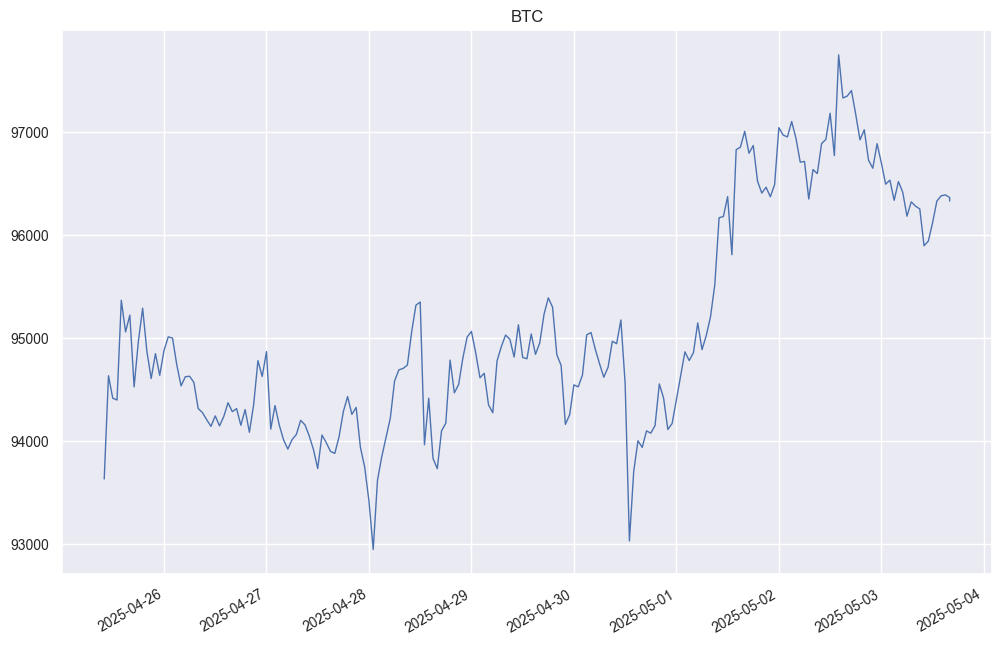

In [13]:
data[-200:][TARGET].plot()
plt.title('BTC')
plt.show()

## Функции подготовки данных и оптимизации модели

In [14]:
import pandas as pd
import numpy as np

# TARGET должна быть определена глобально, например:
# TARGET = 'Price'

# Функция code_mean остается без изменений, она универсальна
def code_mean(data_subset, cat_feature, real_feature):
    """Рассчитывает среднее значение real_feature для каждой категории cat_feature."""
    return dict(data_subset.groupby(cat_feature)[real_feature].mean())

def preprocess_data_hourly_no_leak(data_input: pd.DataFrame,
                                   target_col_name: str,
                                   lags_to_create: list = None,
                                   test_size_hours: int = 7*24):
    """
    Предобработка данных для часовых временных рядов с акцентом на предотвращение утечек.

    Args:
        data_input (pd.DataFrame): Входной DataFrame с DatetimeIndex.
        target_col_name (str): Название целевой колонки.
        lags_to_create (list, optional): Список часов для создания лаговых признаков.
                                         Пример: [1, 2, 24, 168].
                                         Если None, используются дефолтные лаги.
        test_size_hours (int): Размер тестовой выборки в часах.

    Returns:
        tuple: X_train, X_test, y_train, y_test
    """
    if not isinstance(data_input.index, pd.DatetimeIndex):
        raise ValueError("Индекс входных данных должен быть pd.DatetimeIndex.")

    data = data_input.copy()

    if lags_to_create is None:
        lags_to_create = [1, 2, 3, 6, 12, 24, 24*2, 24*3, 24*7] # Дефолтные лаги

    # 1. Создаем лаговые признаки на всем датасете
    for lag in lags_to_create:
        data[f"{target_col_name}_lag_{lag}h"] = data[target_col_name].shift(lag)

    # 2. Создаем временные признаки на всем датасете
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['dayofmonth'] = data.index.day
    data['month'] = data.index.month
    # data['weekofyear'] = data.index.isocalendar().week.astype(int) # Раскомментируй, если нужно

    # 3. Удаляем строки с NaN, появившиеся из-за shift() (лагов)
    # Это важно сделать до вычисления средних и разделения,
    # чтобы индексы были консистентными.
    data = data.dropna()
    
    if data.empty:
        raise ValueError("После создания лагов и удаления NaN не осталось данных. "
                         "Проверьте размер исходных данных и значения лагов.")

    # 4. Определяем индекс разделения на train/test ПОСЛЕ dropna
    # test_size_hours теперь относится к количеству последних строк в ОБРАБОТАННОМ data
    if test_size_hours < 1: # Если передана доля (менее вероятно здесь, но для полноты)
        # Это будет доля от УЖЕ обработанных данных
        num_test_samples = int(len(data) * test_size_hours)
    else:
        num_test_samples = test_size_hours
    
    if num_test_samples >= len(data):
        print(f"Предупреждение: test_size_hours ({num_test_samples}) >= длина обработанных данных ({len(data)}). "
              f"Вся доступная выборка будет использована как обучающая, тестовая будет пустой.")
        split_idx_pos = len(data) # Тестовая выборка будет пустой
    elif num_test_samples <= 0:
        print(f"Предупреждение: test_size_hours ({num_test_samples}) <= 0. "
              f"Вся доступная выборка будет использована как обучающая, тестовая будет пустой.")
        split_idx_pos = len(data) # Тестовая выборка будет пустой
    else:
        split_idx_pos = len(data) - num_test_samples


    train_df = data.iloc[:split_idx_pos].copy() # Явное копирование для избежания SettingWithCopyWarning
    test_df = data.iloc[split_idx_pos:].copy()   # Явное копирование

    # 5. Кодирование средним: вычисляем средние ТОЛЬКО на train_df, применяем к train_df и test_df
    features_for_mean_encoding = ['hour', 'dayofweek', 'dayofmonth', 'month']
    # Если добавляли 'weekofyear', добавьте и его сюда
    
    # Словарь для хранения вычисленных средних (чтобы применить те же к тесту)
    calculated_means = {}

    for feat_cat in features_for_mean_encoding:
        if feat_cat in train_df.columns: # Убедимся, что колонка существует
            # Вычисляем средние на обучающей выборке
            means = code_mean(train_df, feat_cat, target_col_name)
            calculated_means[feat_cat] = means
            
            # Глобальное среднее по трейну для этой категории для заполнения пропусков
            global_mean_target_train_for_feat = train_df[target_col_name].mean() # Это общее среднее, не по категории
                                                                           # Лучше использовать среднее по категории или общее среднее
            if pd.isna(global_mean_target_train_for_feat) and not train_df.empty : # Если трейн не пуст, но среднее NaN (все target NaN)
                 global_mean_target_train_for_feat = 0 # Запасной вариант
            elif train_df.empty:
                 global_mean_target_train_for_feat = 0 # Если трейн пуст


            # Применяем к обучающей выборке
            train_df[f'{feat_cat}_avg_{target_col_name}'] = train_df[feat_cat].map(means)
            train_df[f'{feat_cat}_avg_{target_col_name}'].fillna(global_mean_target_train_for_feat, inplace=True)
            train_df.drop(feat_cat, axis=1, inplace=True)

            # Применяем к тестовой выборке, используя средние, посчитанные на ТРЕЙНЕ
            if feat_cat in test_df.columns:
                test_df[f'{feat_cat}_avg_{target_col_name}'] = test_df[feat_cat].map(means) # Используем те же `means`
                test_df[f'{feat_cat}_avg_{target_col_name}'].fillna(global_mean_target_train_for_feat, inplace=True) # Заполняем тем же глобальным средним из трейна
                test_df.drop(feat_cat, axis=1, inplace=True)
        else:
            print(f"Предупреждение: Категориальный признак '{feat_cat}' не найден в train_df для кодирования средним.")


    # 6. Формируем X_train, y_train, X_test, y_test
    # Убедимся, что целевая колонка есть перед тем как ее удалять из X
    if target_col_name in train_df.columns:
        X_train = train_df.drop(target_col_name, axis=1)
        y_train = train_df[target_col_name]
    else: # Если вдруг целевая колонка пропала (не должно случиться)
        X_train = train_df.copy()
        y_train = pd.Series(index=train_df.index, dtype=float) # Пустая серия
        print(f"ПРЕДУПРЕЖДЕНИЕ: Целевая колонка '{target_col_name}' не найдена в train_df.")

    if target_col_name in test_df.columns:
        X_test = test_df.drop(target_col_name, axis=1)
        y_test = test_df[target_col_name]
    else:
        X_test = test_df.copy()
        y_test = pd.Series(index=test_df.index, dtype=float)
        print(f"ПРЕДУПРЕЖДЕНИЕ: Целевая колонка '{target_col_name}' не найдена в test_df.")


    print(f"Размер X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Размер X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    if X_test.empty or y_test.empty:
        # Это может произойти, если test_size_hours слишком большой или данных мало
        print("ПРЕДУПРЕЖДЕНИЕ: Тестовая выборка пуста! Проверьте test_size_hours и длину данных после создания лагов.")

    return X_train, X_test, y_train, y_test

In [15]:
TARGET = 'Price' # Убедись, что TARGET определена

# Определяем, какие лаги мы хотим создать (в часах)
custom_lags = [1, 2, 3, 6, 12, 23, 24, 25, 47, 48, 49, 167, 168, 169] # (24*7 = 168)

# Размер тестовой выборки: 7 дней * 24 часа
hours_for_test_set = 7 * 24

try:
    X_train, X_test, y_train, y_test = preprocess_data_hourly_no_leak(
        data_input=data, # Твой исходный DataFrame (копия будет создана внутри)
        target_col_name=TARGET,
        lags_to_create=custom_lags,
        test_size_hours=hours_for_test_set
    )

    print("\nПример X_train:")
    if not X_train.empty: display(X_train.head())
    print("\nПример y_train:")
    if not y_train.empty: display(y_train.head())
    print("\nПример X_test:")
    if not X_test.empty: display(X_test.head())
    print("\nПример y_test:")
    if not y_test.empty: display(y_test.head())

except ValueError as e:
    print(f"Ошибка при предобработке данных: {e}")
except Exception as e:
    print(f"Непредвиденная ошибка: {e}")

Размер X_train: (37659, 25), y_train: (37659,)
Размер X_test: (168, 25), y_test: (168,)

Пример X_train:


,Open,High,Low,Change %,avg_overall_sentiment,avg_btc_specific_sentiment,sum_news_count,Price_lag_1h,Price_lag_2h,Price_lag_3h,...,Price_lag_47h,Price_lag_48h,Price_lag_49h,Price_lag_167h,Price_lag_168h,Price_lag_169h,hour_avg_Price,dayofweek_avg_Price,dayofmonth_avg_Price,month_avg_Price
2021-01-08 01:00:00,38793.24,39000.00,37800.00,-0.29,0.0,0.0,0.0,38793.23,39432.28,39665.92,...,33873.30,33811.28,33918.01,29194.65,29409.99,28995.13,46236.476395,46262.607862,45951.241684,48445.295562
2021-01-08 02:00:00,38681.38,38692.83,36500.00,-3.88,0.0,0.0,0.0,38681.37,38793.23,39432.28,...,34117.59,33873.30,33811.28,29278.40,29194.65,29409.99,46220.763548,46262.607862,45951.241684,48445.295562
2021-01-08 03:00:00,37181.74,38460.13,37068.40,3.13,0.0,0.0,0.0,37181.74,38681.37,38793.23,...,35325.91,34117.59,33873.30,29220.31,29278.40,29194.65,46215.163635,46262.607862,45951.241684,48445.295562
2021-01-08 04:00:00,38347.11,38949.97,38155.61,0.84,0.0,0.0,0.0,38347.10,37181.74,38681.37,...,34978.91,35325.91,34117.59,29187.01,29220.31,29278.40,46220.737959,46262.607862,45951.241684,48445.295562
2021-01-08 05:00:00,38668.92,38700.00,37895.00,-1.79,0.0,0.0,0.0,38668.92,38347.10,37181.74,...,35125.51,34978.91,35325.91,29174.35,29187.01,29220.31,46226.086620,46262.607862,45951.241684,48445.295562



Пример y_train:


2021-01-08 01:00:00    38681.37
2021-01-08 02:00:00    37181.74
2021-01-08 03:00:00    38347.10
2021-01-08 04:00:00    38668.92
2021-01-08 05:00:00    37975.25
Name: Price, dtype: float64


Пример X_test:


,Open,High,Low,Change %,avg_overall_sentiment,avg_btc_specific_sentiment,sum_news_count,Price_lag_1h,Price_lag_2h,Price_lag_3h,...,Price_lag_47h,Price_lag_48h,Price_lag_49h,Price_lag_167h,Price_lag_168h,Price_lag_169h,hour_avg_Price,dayofweek_avg_Price,dayofmonth_avg_Price,month_avg_Price
2025-04-26 18:00:00,94316.79,94372.00,94123.50,-0.17,0.294507,0.385132,1.0,94316.79,94286.92,94373.24,...,93556.12,93380.00,93011.28,85085.55,85144.64,85239.92,46236.657196,46279.350145,46283.904098,54845.922127
2025-04-26 19:00:00,94154.71,94334.81,94095.23,0.16,0.000000,0.000000,0.0,94154.71,94316.79,94286.92,...,93390.66,93556.12,93380.00,85195.85,85085.55,85144.64,46225.269146,46279.350145,46283.904098,54845.922127
2025-04-26 20:00:00,94307.51,94380.96,94087.00,-0.23,0.000000,0.000000,0.0,94307.50,94154.71,94316.79,...,93353.72,93390.66,93556.12,85339.53,85195.85,85085.55,46223.624372,46279.350145,46283.904098,54845.922127
2025-04-26 21:00:00,94087.01,94360.00,94087.00,0.29,0.000000,0.000000,0.0,94087.00,94307.50,94154.71,...,93427.98,93353.72,93390.66,85259.86,85339.53,85195.85,46240.321358,46279.350145,46283.904098,54845.922127
2025-04-26 22:00:00,94355.39,94800.00,94355.39,0.45,0.000000,0.000000,0.0,94355.38,94087.00,94307.50,...,93980.47,93427.98,93353.72,85077.01,85259.86,85339.53,46250.788298,46279.350145,46283.904098,54845.922127



Пример y_test:


2025-04-26 18:00:00    94154.71
2025-04-26 19:00:00    94307.50
2025-04-26 20:00:00    94087.00
2025-04-26 21:00:00    94355.38
2025-04-26 22:00:00    94781.86
Name: Price, dtype: float64

Функция кросс-валидации

In [16]:
import numpy as np
from sklearn.metrics import mean_absolute_error
# Предполагается, что model, TARGET, preprocess_data_hourly_no_leak уже определены
# и pandas (pd) импортирован.

# Глобальные переменные, которые должны быть определены до вызова cross_validation:
# TARGET = 'Price' # Имя целевой колонки
# model = lgb.LGBMRegressor(...) # или другая модель
# VALIDATION_FOLD_SIZE_HOURS = 7 * 24 # Размер каждого валидационного фолда в часах

def generate_lags(lag_start, lag_end):
    """Генерирует список лагов от lag_start до lag_end-1."""
    if lag_start >= lag_end:
        # Возвращаем хотя бы один осмысленный лаг или пустой список, если это предпочтительнее
        # В данном случае, если start >= end, это может быть ошибкой в параметрах,
        # но для совместимости с range, вернем пустой список, что приведет к ошибке дальше,
        # или можно вернуть [lag_start] если это логично.
        # Для примера, вернем хотя бы один лаг, если lag_start > 0.
        return [lag_start] if lag_start > 0 else [1] # Возвращаем [1] как дефолтный минимальный лаг
    return list(range(lag_start, lag_end))


def cross_validation_hourly(
    params_to_optimize, # Параметры, которые оптимизируются (например, (lag_s, lag_e) или другие гиперпараметры модели)
    full_data_for_cv: pd.DataFrame, # Весь датасет, доступный для кросс-валидации
    target_col_name: str,
    model_instance, # Экземпляр модели для обучения
    validation_fold_size_hours: int, # Размер каждого валидационного фолда в часах
    num_folds: int = 5,
    # Дополнительные параметры для preprocess_data_hourly_no_leak, если они тоже оптимизируются
    # или фиксированы, но отличаются от дефолтных.
    # Для примера, если оптимизируем только лаги:
    fixed_lags_list: list = None # Если лаги фиксированы и не оптимизируются через params_to_optimize
):
    """
    Выполняет кросс-валидацию для временных рядов с использованием скользящего окна.

    Args:
        params_to_optimize: Кортеж или список оптимизируемых параметров.
                            В данном примере предполагается (lag_start, lag_end).
        full_data_for_cv (pd.DataFrame): Полный DataFrame для кросс-валидации.
        target_col_name (str): Имя целевой колонки.
        model_instance: Экземпляр модели (например, LGBMRegressor).
        validation_fold_size_hours (int): Размер каждого валидационного фолда в часах.
        num_folds (int): Количество фолдов (сдвигов окна).
        fixed_lags_list (list, optional): Если передано, используется этот список лагов
                                         вместо генерации из lag_start, lag_end.

    Returns:
        float: Среднее значение MAE по всем фолдам.
    """

    # Пример распаковки параметров, если они передаются через params_to_optimize
    # Если оптимизируются другие параметры, эту часть нужно изменить
    if fixed_lags_list is None:
        if not (isinstance(params_to_optimize, (list, tuple)) and len(params_to_optimize) == 2):
            raise ValueError("params_to_optimize должен быть кортежем/списком из двух элементов (lag_start, lag_end), "
                             "если fixed_lags_list не предоставлен.")
        lag_s, lag_e = map(int, params_to_optimize) # Убедимся, что это целые числа
        if lag_s <= 0 or lag_e <= lag_s: # Проверка корректности лагов
            print(f"Некорректные параметры лагов: lag_start={lag_s}, lag_end={lag_e}. Возвращаем большое значение MAE.")
            return float('inf') # Штраф за плохие параметры
        lags_for_preprocessing = generate_lags(lag_s, lag_e)
        if not lags_for_preprocessing:
             print(f"Список лагов пуст для lag_start={lag_s}, lag_end={lag_e}. Возвращаем большое значение MAE.")
             return float('inf')
    else:
        lags_for_preprocessing = fixed_lags_list


    scores = []

    # Определяем максимальное количество данных, которое будет использовано в последнем фолде
    # Это полный датасет минус (num_folds - 1) * validation_fold_size_hours на обучение
    # и еще validation_fold_size_hours на последнюю валидацию.
    # Минимальная длина данных для одного фолда: max(lags_for_preprocessing) + validation_fold_size_hours + немного на обучение
    min_data_len_for_fold = (max(lags_for_preprocessing) if lags_for_preprocessing else 0) + validation_fold_size_hours + 1 # +1 для хотя бы одной строки обучения

    for i in range(num_folds):
        # Определяем конец текущего среза данных для этого фолда
        # Начинаем с полного датасета и с каждым фолдом "укорачиваем" его с конца
        # для имитации поступления новых данных в прошлом.
        end_index_for_current_fold_data = len(full_data_for_cv) - i * validation_fold_size_hours
        
        # Данные, доступные для текущего фолда (обучение + валидация этого фолда)
        current_fold_data = full_data_for_cv.iloc[:end_index_for_current_fold_data]

        if len(current_fold_data) < min_data_len_for_fold:
            print(f"Фолд {i+1}/{num_folds}: Недостаточно данных ({len(current_fold_data)}) для создания обучающей и "
                  f"валидационной выборок с лагами до {max(lags_for_preprocessing) if lags_for_preprocessing else 0} "
                  f"и размером валидации {validation_fold_size_hours}. Пропуск фолда.")
            continue # Пропускаем этот фолд, если данных слишком мало

        print(f"\nФолд {i+1}/{num_folds}:")
        print(f"  Данные для фолда: первые {len(current_fold_data)} строк исходного датасета (до индекса {current_fold_data.index[-1] if not current_fold_data.empty else 'N/A'})")
        print(f"  Используемые лаги: {lags_for_preprocessing}")
        print(f"  Размер валидационного набора в этом фолде: {validation_fold_size_hours} часов")

        try:
            X_train, X_valid, y_train, y_valid = preprocess_data_hourly_no_leak(
                data_input=current_fold_data,
                target_col_name=target_col_name,
                lags_to_create=lags_for_preprocessing,
                test_size_hours=validation_fold_size_hours # test_size здесь - это размер валидационного фолда
            )

            if X_train.empty or y_train.empty:
                print(f"  Фолд {i+1}/{num_folds}: Обучающая выборка пуста после предобработки. Пропуск фолда.")
                continue
            if X_valid.empty or y_valid.empty:
                print(f"  Фолд {i+1}/{num_folds}: Валидационная выборка пуста после предобработки. Пропуск фолда.")
                # Это может случиться, если validation_fold_size_hours слишком велик для оставшихся данных после создания лагов
                continue

            # Обучаем модель
            # Для моделей типа LightGBM, XGBoost, можно добавить early_stopping_rounds, verbose и т.д.
            model_instance.fit(X_train, y_train,
                               eval_set=[(X_valid, y_valid)],
                               # early_stopping_rounds=10, # Раскомментируй, если модель поддерживает
                               verbose=False) # Уменьшаем вывод во время CV

            y_pred = model_instance.predict(X_valid)
            mae = mean_absolute_error(y_valid, y_pred)
            scores.append(mae)
            print(f"  Фолд {i+1}/{num_folds}: MAE = {mae:.4f}")

        except ValueError as e:
            print(f"  Фолд {i+1}/{num_folds}: Ошибка при обработке данных или обучении модели: {e}. Пропуск фолда.")
            # Можно добавить очень большую ошибку в scores, чтобы оштрафовать такие параметры
            # scores.append(float('inf'))
            continue
        except Exception as e_general:
            print(f"  Фолд {i+1}/{num_folds}: Непредвиденная ошибка: {e_general}. Пропуск фолда.")
            continue


    if not scores:
        print("Кросс-валидация не дала ни одного результата (все фолды пропущены). "
              "Проверьте параметры, размер данных и validation_fold_size_hours.")
        return float('inf') # Возвращаем "бесконечность" если нет валидных скоров

    cv_score = np.mean(np.array(scores))
    print(f"\nСреднее MAE по {len(scores)} успешным фолдам: {cv_score:.4f}")
    return cv_score

Функция поиска оптимальных параметров модели

In [17]:
import numpy as np
# Предполагается, что cross_validation_hourly, TARGET, model_instance,
# VALIDATION_FOLD_SIZE_HOURS, NUM_CV_FOLDS определены.

def model_optimize_lags(
    full_dataset: pd.DataFrame,      # Полный датасет для оптимизации
    target_col: str,                 # Имя целевой колонки
    model_to_use,                    # Экземпляр модели
    validation_fold_hours: int,      # Размер валидационного фолда в часах
    cv_folds_count: int,             # Количество фолдов в CV
    lag_params_ranges: tuple,        # Кортеж диапазонов для lag_start и lag_end
                                     # ((start_min, start_max, start_step), (end_min, end_max, end_step))
    verbose: bool = False
):
    """
    Оптимизирует параметры lag_start и lag_end для модели временных рядов
    с использованием сеточного поиска и кросс-валидации.

    Args:
        full_dataset (pd.DataFrame): Полный DataFrame для использования в CV.
        target_col (str): Имя целевой колонки.
        model_to_use: Экземпляр модели для обучения.
        validation_fold_hours (int): Размер валидационного фолда в часах для CV.
        cv_folds_count (int): Количество фолдов для CV.
        lag_params_ranges (tuple): ((start_min, start_max, start_step), (end_min, end_max, end_step))
                                   Определяет сетку для перебора lag_start и lag_end.
                                   Например: ((1, 10, 1), (11, 30, 2))
                                   lag_start будет от 1 до 9 с шагом 1.
                                   lag_end будет от 11 до 29 с шагом 2. (Верхняя граница не включается в range)
        verbose (bool): Если True, выводит прогресс.

    Returns:
        tuple: (best_mae, best_lags, lag_params_avg_mae, lag_params_grid_mae)
               best_mae: Лучшее среднее MAE, достигнутое на CV.
               best_lags: Кортеж (best_lag_start, best_lag_end).
               lag_params_avg_mae: Словарь со средними MAE для каждого значения lag_start и lag_end.
               lag_params_grid_mae: Словарь (сетка) со значениями MAE для каждой комбинации (lag_end, lag_start).
    """
    best_lags = (0, 0) # (lag_start, lag_end)
    best_mae = float('inf') # Инициализируем лучшую MAE "бесконечностью"

    # Статистика для усреднения MAE по каждому значению параметра
    lag_params_avg_mae_raw = {
        'start': {}, # {lag_start_value: [mae1, mae2, ...]}
        'end': {}    # {lag_end_value: [mae1, mae2, ...]}
    }
    # Сетка всех MAE для каждой комбинации (для тепловой карты, например)
    lag_params_grid_mae = {} # {lag_end_value: {lag_start_value: mae}}

    start_range_def, end_range_def = lag_params_ranges

    # Итерация по lag_end
    # range(min, max, step) - max не включается. Чтобы включить, нужно max + 1 или max + step
    for lag_e_candidate in range(end_range_def[0], end_range_def[1] + 1, end_range_def[2]):
        # Инициализируем запись в сетке для текущего lag_e_candidate
        if lag_e_candidate not in lag_params_grid_mae:
            lag_params_grid_mae[lag_e_candidate] = {}

        # Итерация по lag_start
        for lag_s_candidate in range(start_range_def[0], start_range_def[1] + 1, start_range_def[2]):
            
            # lag_start должен быть меньше lag_end
            if lag_s_candidate >= lag_e_candidate:
                if verbose:
                    print(f"Пропуск: lag_start ({lag_s_candidate}) >= lag_end ({lag_e_candidate})")
                lag_params_grid_mae[lag_e_candidate][lag_s_candidate] = float('nan') # Отмечаем невалидную комбинацию
                continue

            current_lags_to_optimize = (lag_s_candidate, lag_e_candidate)
            
            if verbose:
                print(f"Тестирование лагов: start={lag_s_candidate}, end={lag_e_candidate}")

            # Выполняем кросс-валидацию
            current_mae = cross_validation_hourly(
                params_to_optimize=current_lags_to_optimize, # (lag_start, lag_end)
                full_data_for_cv=full_dataset,
                target_col_name=target_col,
                model_instance=model_to_use, # Передаем тот же экземпляр, предполагая, что его состояние сбрасывается или не влияет
                validation_fold_size_hours=validation_fold_hours,
                num_folds=cv_folds_count
                # fixed_lags_list=None, т.к. мы генерируем лаги из lag_s_candidate, lag_e_candidate
            )

            # Обновляем лучшую MAE и лучшие параметры
            if current_mae < best_mae:
                best_mae = current_mae
                best_lags = current_lags_to_optimize
                if verbose:
                    print(f"  Новая лучшая MAE: {best_mae:.4f} для лагов {best_lags}")

            # Сохраняем MAE для текущей комбинации в сетке
            lag_params_grid_mae[lag_e_candidate][lag_s_candidate] = current_mae

            # Собираем MAE для усреднения по каждому параметру
            # Для lag_start
            if lag_s_candidate not in lag_params_avg_mae_raw['start']:
                lag_params_avg_mae_raw['start'][lag_s_candidate] = []
            lag_params_avg_mae_raw['start'][lag_s_candidate].append(current_mae)

            # Для lag_end
            if lag_e_candidate not in lag_params_avg_mae_raw['end']:
                lag_params_avg_mae_raw['end'][lag_e_candidate] = []
            lag_params_avg_mae_raw['end'][lag_e_candidate].append(current_mae)

            if verbose:
                print(f"  Лаги ({lag_s_candidate}-{lag_e_candidate}): MAE = {current_mae:.4f}")
    
    # Вычисляем среднее значение MAE для каждого варианта параметра
    lag_params_avg_mae_final = {'start': {}, 'end': {}}
    for param_type, values_dict in lag_params_avg_mae_raw.items():
        for param_value, mae_list in values_dict.items():
            if mae_list: # Если список не пуст
                 # Отфильтруем inf значения, если они попали из cross_validation_hourly
                valid_mae_list = [m for m in mae_list if m != float('inf') and not np.isnan(m)]
                if valid_mae_list:
                    lag_params_avg_mae_final[param_type][param_value] = np.mean(valid_mae_list)
                else:
                    lag_params_avg_mae_final[param_type][param_value] = float('inf') # или np.nan
            else: # Если список пуст (не должно быть, если цикл прошел)
                lag_params_avg_mae_final[param_type][param_value] = float('inf') # или np.nan


    print(f"\nОптимизация лагов завершена.")
    print(f"Лучшее MAE: {best_mae:.4f}")
    print(f"Лучшие лаги (start, end): {best_lags}")

    return best_mae, best_lags, lag_params_avg_mae_final, lag_params_grid_mae

## Оптимизация параметров модели

Установим общие параметры модели

In [18]:
from catboost import CatBoostRegressor
import numpy as np # для np.inf, np.isnan если они могут появиться
import pandas as pd # на случай если data_valid это DataFrame

# Предполагается, что TARGET, VALIDATION_FOLD_SIZE_HOURS, NUM_CV_FOLDS,
# model_optimize_lags, cross_validation_hourly определены ранее.
# RANDOM_SEED также должен быть определен.

# --- Определение глобальных переменных (если они еще не определены) ---
RANDOM_SEED = 42 # Пример
TARGET = 'Price'    # Пример
VALIDATION_FOLD_SIZE_HOURS = 24 * 7 # Пример: 7 дней
NUM_CV_FOLDS = 3 # Пример: 3 фолда для скорости

# --- Создание экземпляра модели CatBoost ---
# Убедимся, что используем правильные имена параметров для CatBoost
# 'random_seed' или 'random_state'. 'loss_function' можно указать явно (MAE, RMSE и т.д.)
# 'eval_metric' также важно указать, если хотим видеть его во время verbose обучения.
# 'logging_level': 'Silent' (аналог verbose=False), 'Verbose', 'Info', 'Debug'
catboost_model_params = {
    'n_estimators': 900,
    'random_state': RANDOM_SEED, # или 'random_seed': RANDOM_SEED
    'logging_level': 'Silent',   # Отключает вывод CatBoost во время fit
    'loss_function': 'MAE',      # Явно указываем MAE, если это наша основная метрика
    'eval_metric': 'MAE'         # Метрика для eval_set
}
model_for_opt = CatBoostRegressor(**catboost_model_params)

# --- Определение данных для оптимизации ---
# data_valid должна быть определена ранее, это DataFrame с историческими данными
# Например:
# data_valid = data[:-TEST_SIZE_FINAL_MODEL] # если есть финальный тестовый набор
# или data_valid = data.copy() если весь data используется для CV

# Для примера, создадим data_valid, если его нет
if 'data_valid' not in locals() or not isinstance(data_valid, pd.DataFrame) or data_valid.empty:
    print("Предупреждение: 'data_valid' не определен или пуст. Создаю пример DataFrame.")
    rng_opt = pd.date_range(start='2022-01-01', periods=500, freq='H') # меньше данных для скорости примера
    data_valid = pd.DataFrame(index=rng_opt, data={TARGET: np.random.rand(500) * 100 + 20000})


# --- Определение диапазонов для оптимизации лагов ---
# Формат: ((start_min, start_max, start_step), (end_min, end_max, end_step))
# start_max и end_max будут ВКЛЮЧЕНЫ в перебор в model_optimize_lags
# Твой формат: [[7, 10, 1], [15, 35, 5]]
# lag_start: от 7 до 10 включительно, с шагом 1  (7, 8, 9, 10)
# lag_end: от 15 до 35 включительно, с шагом 5 (15, 20, 25, 30, 35)
lag_ranges_for_optimization = (
    (7, 10, 1),   # (min_start_lag, max_start_lag, step_start_lag)
    (15, 35, 5)   # (min_end_lag, max_end_lag, step_end_lag)
)

print("Начало оптимизации параметров лагов...")
# (выполнение может занять время в зависимости от размера данных и диапазонов)

best_mae, best_lag_params_tuple, lag_avg_mae_statistics, lag_grid_mae_values = model_optimize_lags(
    full_dataset=data_valid,
    target_col=TARGET,
    model_to_use=model_for_opt, # Передаем наш экземпляр CatBoost
    validation_fold_hours=VALIDATION_FOLD_SIZE_HOURS,
    cv_folds_count=NUM_CV_FOLDS,
    lag_params_ranges=lag_ranges_for_optimization,
    verbose=True # Включим вывод для отслеживания прогресса
)

print("\n--- Результаты оптимизации лагов ---")
print(f"Лучшая MAE по кросс-валидации: {best_mae:.4f}")

# Лучшие параметры (пара, давшая наименьший MAE напрямую)
best_lag_start_from_opt, best_lag_end_from_opt = best_lag_params_tuple
print(f"Лучшие параметры лагов (start, end) из оптимизации: ({best_lag_start_from_opt}, {best_lag_end_from_opt})")

# "Оптимальные" параметры, найденные по минимальному среднему MAE для каждого параметра отдельно
# (могут не совпадать с best_lag_params_tuple, так как это усредненные по одному измерению)

# Убедимся, что словари не пустые перед поиском min
if lag_avg_mae_statistics['start']:
    # Фильтруем np.inf и np.nan перед поиском минимума
    valid_start_stats = {k: v for k, v in lag_avg_mae_statistics['start'].items() if v != float('inf') and not np.isnan(v)}
    if valid_start_stats:
        individual_opt_lag_start = int(min(valid_start_stats, key=valid_start_stats.get))
        print(f"Индивидуально оптимальный lag_start (по среднему MAE): {individual_opt_lag_start} (MAE: {valid_start_stats[individual_opt_lag_start]:.4f})")
    else:
        individual_opt_lag_start = None
        print("Не удалось определить индивидуально оптимальный lag_start (все MAE были inf/nan).")
else:
    individual_opt_lag_start = None
    print("Статистика для lag_start пуста.")


if lag_avg_mae_statistics['end']:
    valid_end_stats = {k: v for k, v in lag_avg_mae_statistics['end'].items() if v != float('inf') and not np.isnan(v)}
    if valid_end_stats:
        individual_opt_lag_end = int(min(valid_end_stats, key=valid_end_stats.get))
        print(f"Индивидуально оптимальный lag_end (по среднему MAE): {individual_opt_lag_end} (MAE: {valid_end_stats[individual_opt_lag_end]:.4f})")
    else:
        individual_opt_lag_end = None
        print("Не удалось определить индивидуально оптимальный lag_end (все MAE были inf/nan).")
else:
    individual_opt_lag_end = None
    print("Статистика для lag_end пуста.")

# Вы можете выбрать, какие параметры использовать дальше:
# 1. best_lag_start_from_opt, best_lag_end_from_opt (наилучшая пара)
# 2. individual_opt_lag_start, individual_opt_lag_end (лучшие по отдельности, их комбинация не обязательно лучшая)

# Для дальнейшего использования обычно берут лучшую пару:
final_lag_start = best_lag_start_from_opt
final_lag_end = best_lag_end_from_opt
print(f"\nВыбранные параметры для дальнейшего использования: lag_start={final_lag_start}, lag_end={final_lag_end}")

# Можно также вывести сетку MAE для анализа, если нужно
# print("\nСетка MAE (lag_end: {lag_start: MAE}):")
# for e_lag, start_dict in lag_grid_mae_values.items():
#    print(f"  lag_end = {e_lag}:")
#    for s_lag, mae_val in start_dict.items():
#        if not np.isnan(mae_val): # Не выводим NaN (пропущенные из-за s_lag >= e_lag)
#            print(f"    lag_start = {s_lag}: MAE = {mae_val:.4f}")

Предупреждение: 'data_valid' не определен или пуст. Создаю пример DataFrame.
Начало оптимизации параметров лагов...
Тестирование лагов: start=7, end=15

Фолд 1/3:
  Данные для фолда: первые 500 строк исходного датасета (до индекса 2022-01-21 19:00:00)
  Используемые лаги: [7, 8, 9, 10, 11, 12, 13, 14]
  Размер валидационного набора в этом фолде: 168 часов
Размер X_train: (318, 12), y_train: (318,)
Размер X_test: (168, 12), y_test: (168,)
  Фолд 1/3: MAE = 27.5076

Фолд 2/3:
  Данные для фолда: первые 332 строк исходного датасета (до индекса 2022-01-14 19:00:00)
  Используемые лаги: [7, 8, 9, 10, 11, 12, 13, 14]
  Размер валидационного набора в этом фолде: 168 часов
Размер X_train: (150, 12), y_train: (150,)
Размер X_test: (168, 12), y_test: (168,)
  Фолд 2/3: MAE = 25.5027
Фолд 3/3: Недостаточно данных (164) для создания обучающей и валидационной выборок с лагами до 14 и размером валидации 168. Пропуск фолда.

Среднее MAE по 2 успешным фолдам: 26.5052
  Новая лучшая MAE: 26.5052 для ла

Выведем диаграмму метрики для всех сочетаний параметров, а также среднюю величину метрики для отдельных значений подбираемых параметров

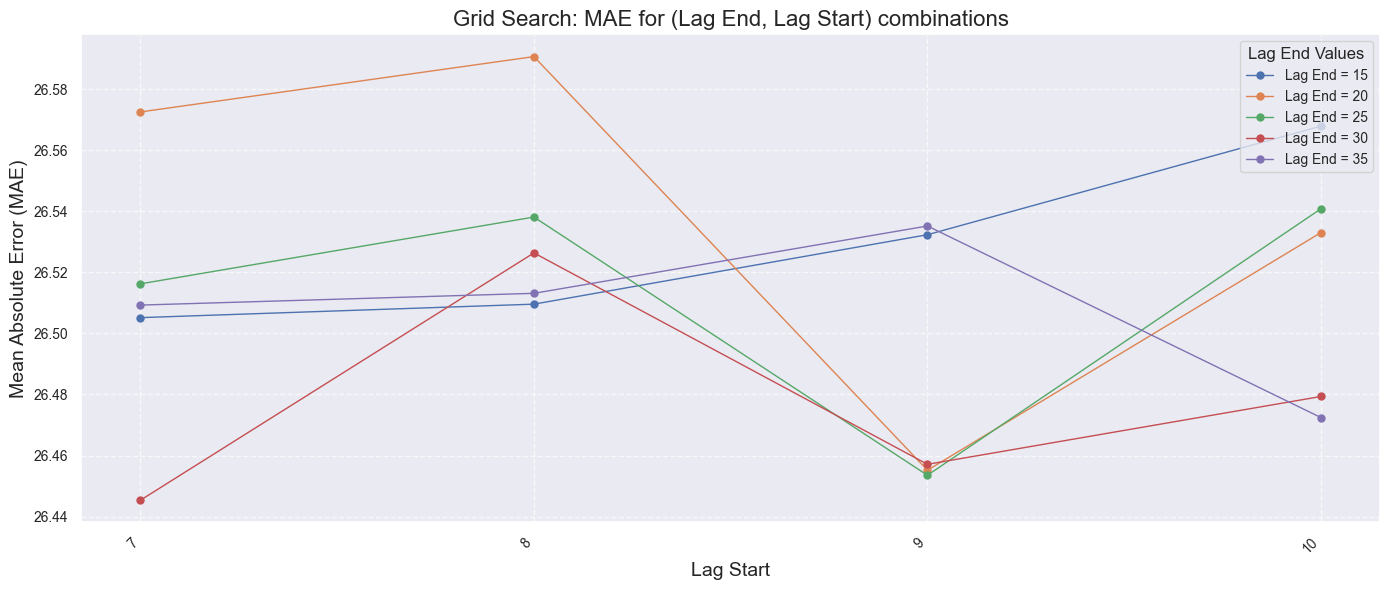

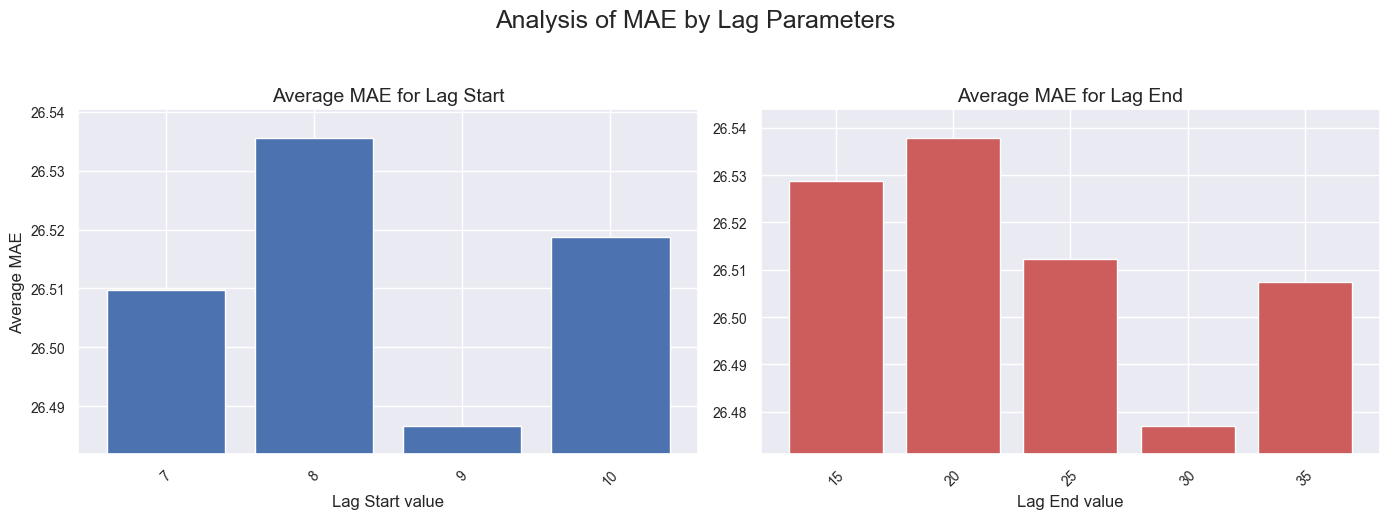

In [19]:
import matplotlib.pyplot as plt
import numpy as np # Для обработки NaN, если потребуется

# Предполагается, что lag_grid_mae_values и lag_avg_mae_statistics
# были получены из model_optimize_lags и доступны.

# --- График 1: Сетка параметров (Parameters grid) ---
plt.figure(figsize=(14, 6)) # Немного увеличил размер для лучшей читаемости
plt.title('Grid Search: MAE for (Lag End, Lag Start) combinations', fontsize=16)

# Сортируем ключи lag_end для более упорядоченного графика и легенды
sorted_lag_end_keys = sorted(lag_grid_mae_values.keys())

# Найдем все уникальные значения lag_start для корректных xticks
all_lag_start_keys = set()
for lag_end_key in sorted_lag_end_keys:
    if lag_grid_mae_values[lag_end_key]: # Проверяем, что словарь не пуст
        all_lag_start_keys.update(lag_grid_mae_values[lag_end_key].keys())
sorted_all_lag_start_keys = sorted(list(all_lag_start_keys))

# Построение линий для каждого lag_end
for lag_end_key in sorted_lag_end_keys:
    lag_start_to_mae_map = lag_grid_mae_values[lag_end_key]
    if not lag_start_to_mae_map: # Пропускаем, если для этого lag_end нет данных
        continue

    # Готовим данные для plot: сортируем по lag_start
    # и обрабатываем NaN (если они есть как float('nan'))
    plot_data_x = []
    plot_data_y = []
    
    temp_plot_data = sorted(lag_start_to_mae_map.items()) # [(lag_start, mae), ...]
    
    for lag_start, mae in temp_plot_data:
        plot_data_x.append(lag_start)
        plot_data_y.append(mae) # matplotlib.plot сам обработает np.nan, пропуская точку

    plt.plot(plot_data_x, plot_data_y, 'o-', label=f'Lag End = {lag_end_key}', markersize=5)

if sorted_all_lag_start_keys: # Если есть хоть какие-то данные
    plt.xticks(sorted_all_lag_start_keys, rotation=45, ha="right")
plt.xlabel('Lag Start', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)
plt.legend(loc='upper right', title='Lag End Values')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout() # Для лучшего расположения элементов
plt.show()


# --- График 2: Средние MAE для каждого значения параметра ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5)) # Немного увеличил размер

# График для lag_start
start_stats = lag_avg_mae_statistics.get('start', {})
if start_stats:
    # Фильтруем NaN и inf перед построением, чтобы избежать ошибок и пустых баров
    valid_start_stats = {k: v for k, v in start_stats.items() if v != float('inf') and not np.isnan(v)}
    if valid_start_stats:
        sorted_start_keys = sorted(valid_start_stats.keys())
        start_values = [valid_start_stats[k] for k in sorted_start_keys]

        ax[0].bar([str(k) for k in sorted_start_keys], start_values) # Используем str(k) для меток, если ключи числовые
        # ax[0].set_xticks([str(k) for k in sorted_start_keys]) # Не нужно, если метки уже строки
        ax[0].set_title('Average MAE for Lag Start', fontsize=14)
        ax[0].set_xlabel('Lag Start value', fontsize=12)
        ax[0].set_ylabel('Average MAE', fontsize=12)
        ax[0].tick_params(axis='x', rotation=45)
        
        # Динамический ylim, если не хотим фиксированный
        if start_values:
            min_val_s = min(start_values)
            max_val_s = max(start_values)
            padding_s = (max_val_s - min_val_s) * 0.1 # 10% от диапазона
            ax[0].set_ylim([min_val_s - padding_s if min_val_s > padding_s else 0 , max_val_s + padding_s]) # Убедимся что не уходим в минус
    else:
        ax[0].text(0.5, 0.5, 'No valid data for Lag Start stats', ha='center', va='center')
        ax[0].set_title('Average MAE for Lag Start', fontsize=14)
else:
    ax[0].text(0.5, 0.5, 'No data for Lag Start stats', ha='center', va='center')
    ax[0].set_title('Average MAE for Lag Start', fontsize=14)


# График для lag_end
end_stats = lag_avg_mae_statistics.get('end', {})
if end_stats:
    valid_end_stats = {k: v for k, v in end_stats.items() if v != float('inf') and not np.isnan(v)}
    if valid_end_stats:
        sorted_end_keys = sorted(valid_end_stats.keys())
        end_values = [valid_end_stats[k] for k in sorted_end_keys]

        ax[1].bar([str(k) for k in sorted_end_keys], end_values, color='indianred') # Изменил цвет для разнообразия
        # ax[1].set_xticks([str(k) for k in sorted_end_keys])
        ax[1].set_title('Average MAE for Lag End', fontsize=14)
        ax[1].set_xlabel('Lag End value', fontsize=12)
        # ax[1].set_ylabel('Average MAE') # Ось Y общая, можно не дублировать
        ax[1].tick_params(axis='x', rotation=45)

        if end_values:
            min_val_e = min(end_values)
            max_val_e = max(end_values)
            padding_e = (max_val_e - min_val_e) * 0.1
            ax[1].set_ylim([min_val_e - padding_e if min_val_e > padding_e else 0, max_val_e + padding_e])
    else:
        ax[1].text(0.5, 0.5, 'No valid data for Lag End stats', ha='center', va='center')
        ax[1].set_title('Average MAE for Lag End', fontsize=14)
else:
    ax[1].text(0.5, 0.5, 'No data for Lag End stats', ha='center', va='center')
    ax[1].set_title('Average MAE for Lag End', fontsize=14)

fig.suptitle('Analysis of MAE by Lag Parameters', fontsize=18, y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Оставляем место для suptitle
plt.show()

### Перебор оптимальных сочетаний параметров

Рассчитаем и сохраним прогнозы модели на тестовых данных, перебирая ряд параметров с фиксированием значения оптимального параметра

In [20]:
import pandas as pd
import numpy as np
# Предполагается, что:
# - TARGET определен (например, 'Price')
# - model_for_opt - это ваш настроенный экземпляр CatBoostRegressor
# - individual_opt_lag_start и individual_opt_lag_end определены из предыдущего шага
# - preprocess_data_hourly_no_leak определена
# - data - это ваш ПОЛНЫЙ DataFrame с данными (включая период для финального теста)
# - generate_lags определена (возьмем ее из предыдущего кода)

# --- Вспомогательная функция (если не определена в этой ячейке) ---
def generate_lags(lag_start, lag_end):
    """Генерирует список лагов от lag_start до lag_end-1."""
    if lag_start >= lag_end:
       return [lag_start] if lag_start > 0 else [1]
    return list(range(lag_start, lag_end))

# --- Параметры ---
# Размер финального тестового набора, на котором делаем эти прогнозы
FINAL_TEST_SIZE_HOURS = 24 * 7 # Пример: 7 дней

# --- Проверка наличия оптимальных параметров ---
if 'individual_opt_lag_start' not in locals() or individual_opt_lag_start is None:
    print("Ошибка: individual_opt_lag_start не определен. Запустите предыдущую ячейку.")
    exit() # или присвоить значение по умолчанию, если это допустимо

if 'individual_opt_lag_end' not in locals() or individual_opt_lag_end is None:
     print("Ошибка: individual_opt_lag_end не определен. Запустите предыдущую ячейку.")
     exit() # или присвоить значение по умолчанию


print(f"--- Генерация прогнозов с фиксированным lag_start = {individual_opt_lag_start} ---")
# ряд для оптимального значения lag_start_opt
# Используем тот же диапазон, что и в оригинальном коде
for lag_end_candidate in range(15, 40, 5): # 15, 20, 25, 30, 35

    if individual_opt_lag_start >= lag_end_candidate:
         print(f"Пропуск: lag_start ({individual_opt_lag_start}) >= lag_end ({lag_end_candidate})")
         continue

    print(f"  Обработка для lag_end = {lag_end_candidate}...")
    try:
        lags_list = generate_lags(individual_opt_lag_start, lag_end_candidate)
        X_train, X_test, y_train, y_test = preprocess_data_hourly_no_leak(
            data_input=data, # Используем полный набор данных
            target_col_name=TARGET,
            lags_to_create=lags_list,
            test_size_hours=FINAL_TEST_SIZE_HOURS # Размер финального теста
        )

        if X_test.empty or y_test.empty:
             print(f"  Предупреждение: Тестовая выборка пуста для lag_end={lag_end_candidate}. Пропуск.")
             continue

        # Обучаем модель на данных до финального теста
        model_for_opt.fit(X_train, y_train)
        preds = model_for_opt.predict(X_test)

        # Создаем результат с правильным DatetimeIndex
        X_result = pd.DataFrame(data=preds, index=y_test.index, columns=[TARGET])

        # Сохраним прогноз в файл
        filename = f'prediction_catboost_start_{individual_opt_lag_start}-end_{lag_end_candidate}.csv'
        X_result.to_csv(filename)
        print(f"  Прогноз сохранен в {filename}")

    except Exception as e:
         print(f"  Ошибка при обработке lag_end={lag_end_candidate}: {e}")


print(f"\n--- Генерация прогнозов с фиксированным lag_end = {individual_opt_lag_end} ---")
# ряд для оптимального значения lag_end_opt
# Используем тот же диапазон, что и в оригинальном коде
for lag_start_candidate in range(7, 11, 1): # 7, 8, 9, 10

    if lag_start_candidate >= individual_opt_lag_end:
         print(f"Пропуск: lag_start ({lag_start_candidate}) >= lag_end ({individual_opt_lag_end})")
         continue

    print(f"  Обработка для lag_start = {lag_start_candidate}...")
    try:
        lags_list = generate_lags(lag_start_candidate, individual_opt_lag_end)
        X_train, X_test, y_train, y_test = preprocess_data_hourly_no_leak(
            data_input=data, # Используем полный набор данных
            target_col_name=TARGET,
            lags_to_create=lags_list,
            test_size_hours=FINAL_TEST_SIZE_HOURS # Размер финального теста
        )

        if X_test.empty or y_test.empty:
             print(f"  Предупреждение: Тестовая выборка пуста для lag_start={lag_start_candidate}. Пропуск.")
             continue

        # Обучаем модель на данных до финального теста
        model_for_opt.fit(X_train, y_train)
        preds = model_for_opt.predict(X_test)

        # Создаем результат с правильным DatetimeIndex
        X_result = pd.DataFrame(data=preds, index=y_test.index, columns=[TARGET])

        # сохраним прогноз в файл
        filename = f'prediction_catboost_start_{lag_start_candidate}-end_{individual_opt_lag_end}.csv'
        X_result.to_csv(filename)
        print(f"  Прогноз сохранен в {filename}")

    except Exception as e:
        print(f"  Ошибка при обработке lag_start={lag_start_candidate}: {e}")

print("\nГенерация прогнозов завершена.")

--- Генерация прогнозов с фиксированным lag_start = 9 ---
  Обработка для lag_end = 15...
Размер X_train: (37814, 17), y_train: (37814,)
Размер X_test: (168, 17), y_test: (168,)
  Прогноз сохранен в prediction_catboost_start_9-end_15.csv
  Обработка для lag_end = 20...
Размер X_train: (37809, 22), y_train: (37809,)
Размер X_test: (168, 22), y_test: (168,)
  Прогноз сохранен в prediction_catboost_start_9-end_20.csv
  Обработка для lag_end = 25...
Размер X_train: (37804, 27), y_train: (37804,)
Размер X_test: (168, 27), y_test: (168,)
  Прогноз сохранен в prediction_catboost_start_9-end_25.csv
  Обработка для lag_end = 30...
Размер X_train: (37799, 32), y_train: (37799,)
Размер X_test: (168, 32), y_test: (168,)
  Прогноз сохранен в prediction_catboost_start_9-end_30.csv
  Обработка для lag_end = 35...
Размер X_train: (37794, 37), y_train: (37794,)
Размер X_test: (168, 37), y_test: (168,)
  Прогноз сохранен в prediction_catboost_start_9-end_35.csv

--- Генерация прогнозов с фиксированным l

## Оптимальный вариант (результат на kaggle: **212.58**)

In [21]:
lag_start = 10
lag_end = 35

### Обучение модели и прогнозирование

Рассчитаем прогноз модели с лучшими подобранными параметрами на тестовых данных

In [22]:
import pandas as pd
# Предполагается, что:
# - TARGET определен (например, 'Price')
# - preprocess_data_hourly_no_leak определена
# - data - это ваш ПОЛНЫЙ DataFrame с данными (включая период для финального теста)
# - generate_lags определена (возьмем ее из предыдущего кода)
# - lag_start_win и lag_end_win определены как 10 и 35 соответственно

# --- Вспомогательная функция (если не определена в этой ячейке) ---
def generate_lags(lag_start, lag_end):
    """Генерирует список лагов от lag_start до lag_end-1."""
    if lag_start >= lag_end:
       # Возвращаем хотя бы один осмысленный лаг или пустой список, если это предпочтительнее
       # В данном случае, если start >= end, это может быть ошибкой в параметрах,
       # но для совместимости с range, вернем пустой список, что приведет к ошибке дальше,
       # или можно вернуть [lag_start] если это логично.
       # Для примера, вернем хотя бы один лаг, если lag_start > 0.
        return [lag_start] if lag_start > 0 else [1] # Возвращаем [1] как дефолтный минимальный лаг
    return list(range(lag_start, lag_end))


# --- Параметры ---
# Победившие параметры лагов из предыдущего шага
lag_start_win = 10
lag_end_win = 35

# Размер финального тестового набора, который был отложен
FINAL_TEST_SIZE_HOURS = 24 * 7 # Убедись, что это то же значение, что и ранее

# Глобальная переменная (если не определена)
TARGET = 'Price'

# Генерируем список лагов на основе победивших параметров
final_lags_list = generate_lags(lag_start_win, lag_end_win)

print(f"Использование выбранных лагов: start={lag_start_win}, end={lag_end_win}")
print(f"  Список лагов для предобработки: {final_lags_list[:3]}...{final_lags_list[-3:]} (всего {len(final_lags_list)})")
print(f"Размер финального тестового набора: {FINAL_TEST_SIZE_HOURS} часов")


# --- Предобработка данных для финального теста ---
try:
    X_train, X_test, y_train, y_test = preprocess_data_hourly_no_leak(
        data_input=data, # Используем полный набор данных
        target_col_name=TARGET,
        lags_to_create=final_lags_list, # Передаем список лагов
        test_size_hours=FINAL_TEST_SIZE_HOURS # Размер финального теста
    )

    print('\nTrain length:', len(y_train))
    print('Test length:', len(y_test))

    print("\nПервые 5 строк X_test:")
    # Используем display() если в Jupyter/IPython, иначе print()
    try:
        from IPython.display import display
        display(X_test.head())
    except ImportError:
        print(X_test.head())
        
    # Проверим также размерности
    print(f"\nРазмерности: X_train={X_train.shape}, y_train={y_train.shape}, X_test={X_test.shape}, y_test={y_test.shape}")
    
    if X_test.empty or y_test.empty:
         print("\nПРЕДУПРЕЖДЕНИЕ: Финальная тестовая выборка пуста после предобработки!")


except Exception as e:
    print(f"\nОшибка при финальной предобработке данных: {e}")

Использование выбранных лагов: start=10, end=35
  Список лагов для предобработки: [10, 11, 12]...[32, 33, 34] (всего 25)
Размер финального тестового набора: 168 часов
Размер X_train: (37794, 36), y_train: (37794,)
Размер X_test: (168, 36), y_test: (168,)

Train length: 37794
Test length: 168

Первые 5 строк X_test:


,Open,High,Low,Change %,avg_overall_sentiment,avg_btc_specific_sentiment,sum_news_count,Price_lag_10h,Price_lag_11h,Price_lag_12h,...,Price_lag_29h,Price_lag_30h,Price_lag_31h,Price_lag_32h,Price_lag_33h,Price_lag_34h,hour_avg_Price,dayofweek_avg_Price,dayofmonth_avg_Price,month_avg_Price
2025-04-26 18:00:00,94316.79,94372.00,94123.50,-0.17,0.294507,0.385132,1.0,94318.04,94570.31,94630.42,...,94400.01,94417.29,94635.67,93634.02,93816.42,93680.01,46190.341022,46241.381646,46283.904098,54845.922127
2025-04-26 19:00:00,94154.71,94334.81,94095.23,0.16,0.000000,0.000000,0.0,94277.65,94318.04,94570.31,...,95368.00,94400.01,94417.29,94635.67,93634.02,93816.42,46179.357892,46241.381646,46283.904098,54845.922127
2025-04-26 20:00:00,94307.51,94380.96,94087.00,-0.23,0.000000,0.000000,0.0,94209.03,94277.65,94318.04,...,95061.22,95368.00,94400.01,94417.29,94635.67,93634.02,46177.523473,46241.381646,46283.904098,54845.922127
2025-04-26 21:00:00,94087.01,94360.00,94087.00,0.29,0.000000,0.000000,0.0,94144.06,94209.03,94277.65,...,95223.81,95061.22,95368.00,94400.01,94417.29,94635.67,46194.661784,46241.381646,46283.904098,54845.922127
2025-04-26 22:00:00,94355.39,94800.00,94355.39,0.45,0.000000,0.000000,0.0,94245.90,94144.06,94209.03,...,94527.79,95223.81,95061.22,95368.00,94400.01,94417.29,46205.665181,46241.381646,46283.904098,54845.922127



Размерности: X_train=(37794, 36), y_train=(37794,), X_test=(168, 36), y_test=(168,)


Обучение финальной модели на X_train...
Получение предсказаний на X_test...


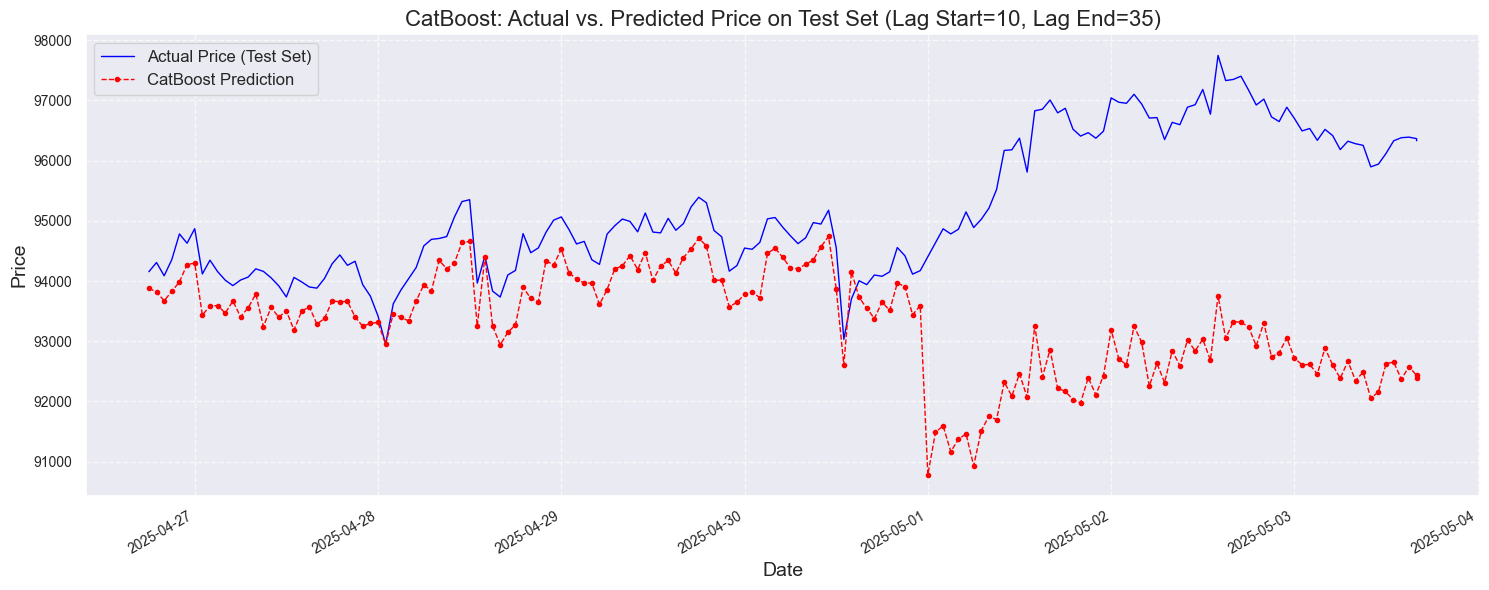


Метрики на финальном тестовом наборе:
  MAE: 1902.6393
  RMSE: 2516.1142


In [23]:
import matplotlib.pyplot as plt
import pandas as pd # Для создания DataFrame для графика

# Предполагается, что:
# - model_for_opt (экземпляр CatBoostRegressor) определен и настроен
# - X_train, y_train, X_test, y_test получены из предыдущей ячейки
# - TARGET определен

# --- Обучение финальной модели и предсказание ---
# Убедимся, что X_train и X_test не пусты, прежде чем обучать и предсказывать
if 'X_train' in locals() and not X_train.empty and 'X_test' in locals() and not X_test.empty:
    print("Обучение финальной модели на X_train...")
    try:
        # Используем модель, которая была настроена (например, model_for_opt)
        # Если вы хотите, чтобы модель обучалась с выводом, измените 'logging_level' в ее параметрах
        model_for_opt.fit(X_train, y_train)
        
        print("Получение предсказаний на X_test...")
        final_predictions = model_for_opt.predict(X_test)

        # --- Визуализация предсказаний ---
        plt.figure(figsize=(15, 6)) # Немного увеличим размер для наглядности

        # Для корректного отображения на временной оси, создадим Pandas Series
        # с предсказаниями и временным индексом из y_test
        predictions_series = pd.Series(final_predictions, index=y_test.index, name='Prediction')
        
        # Отобразим реальные значения y_test для сравнения
        y_test.plot(label='Actual Price (Test Set)', color='blue', linestyle='-')
        
        # Отобразим предсказания
        predictions_series.plot(label='CatBoost Prediction', color='red', linestyle='--', marker='o', markersize=3)
        
        plt.title(f"CatBoost: Actual vs. Predicted Price on Test Set (Lag Start={lag_start_win}, Lag End={lag_end_win})", fontsize=16)
        plt.xlabel("Date", fontsize=14)
        plt.ylabel(TARGET, fontsize=14) # Используем имя целевой переменной
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Дополнительно можно вывести метрики на тестовом наборе
        from sklearn.metrics import mean_absolute_error, mean_squared_error
        
        mae_final_test = mean_absolute_error(y_test, final_predictions)
        rmse_final_test = np.sqrt(mean_squared_error(y_test, final_predictions))
        
        print(f"\nМетрики на финальном тестовом наборе:")
        print(f"  MAE: {mae_final_test:.4f}")
        print(f"  RMSE: {rmse_final_test:.4f}")
        
        # Сравнение с MAE, полученной на кросс-валидации (если она доступна)
        if 'best_mae_opt' in locals(): # Предполагаем, что эта переменная есть из оптимизации
            print(f"  Для сравнения, лучшая MAE на кросс-валидации была: {best_mae_opt:.4f}")

    except Exception as e:
        print(f"Ошибка во время обучения или предсказания: {e}")

else:
    print("X_train или X_test не определены или пусты. Обучение и предсказание не выполнены.")

Выведем график значимости признаков

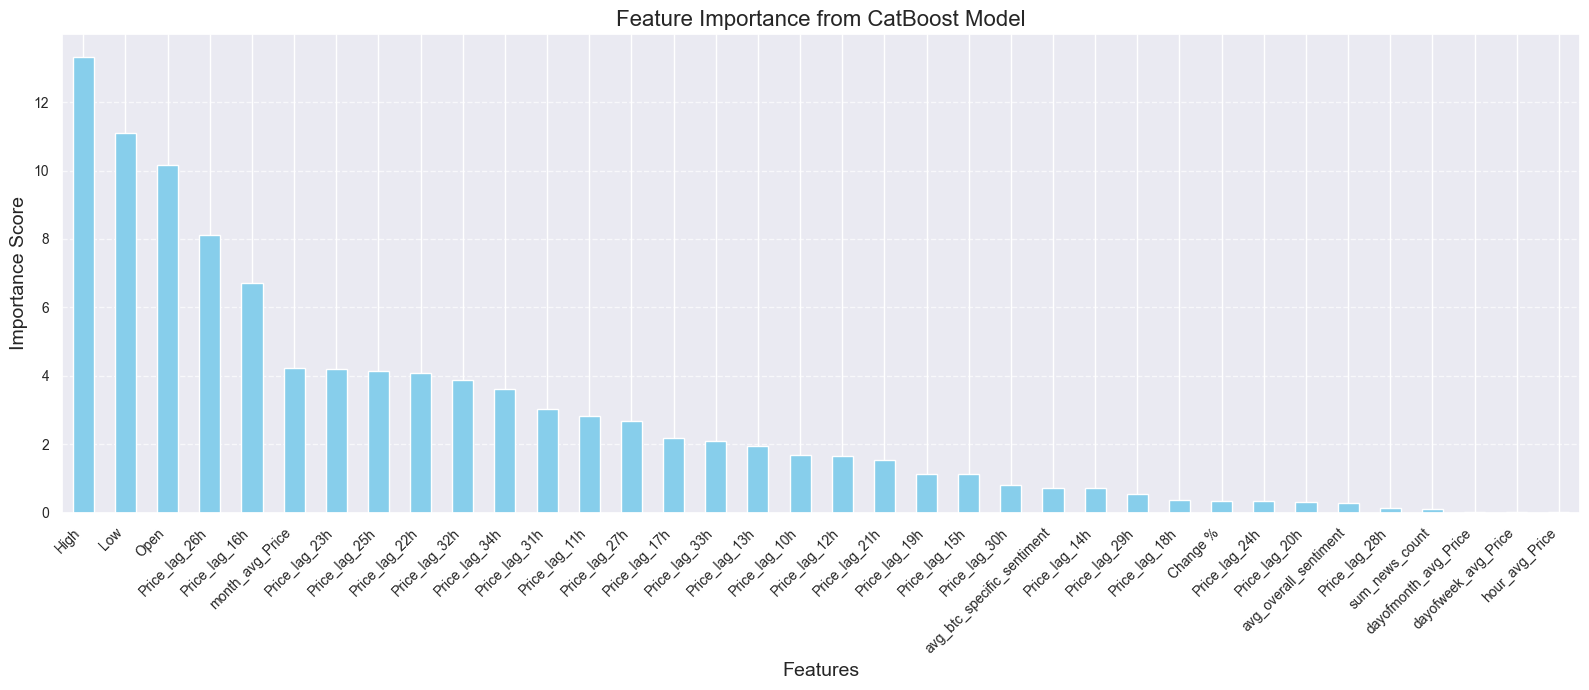


Топ-10 самых важных признаков:
High               13.314167
Low                11.108762
Open               10.169572
Price_lag_26h       8.109500
Price_lag_16h       6.712946
month_avg_Price     4.211833
Price_lag_23h       4.191890
Price_lag_25h       4.137499
Price_lag_22h       4.069482
Price_lag_32h       3.875504
dtype: float64


In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Предполагается, что:
# - model_for_opt (экземпляр CatBoostRegressor) был обучен на X_train
# - X_train (или X_test, если их колонки идентичны и соответствуют тому, на чем обучалась модель) доступен
#   и содержит правильные имена колонок. Обычно лучше использовать X_train.columns,
#   так как модель обучалась именно на них.

# --- Получение и визуализация важности признаков ---
# Убедимся, что модель была обучена и X_train существует
if 'model_for_opt' in locals() and hasattr(model_for_opt, 'get_feature_importance') and \
   'X_train' in locals() and not X_train.empty: # Используем X_train.columns для большей корректности

    try:
        feature_importances = model_for_opt.get_feature_importance()
        
        # Создаем Pandas Series для удобства отображения
        # Важно использовать колонки из X_train, так как модель обучалась на них
        features_strength_series = pd.Series(feature_importances, index=X_train.columns)
        
        # Сортируем признаки по важности для лучшей визуализации
        features_strength_series_sorted = features_strength_series.sort_values(ascending=False)

        # --- Визуализация ---
        plt.figure(figsize=(16, 7)) # Можно настроить размер
        
        features_strength_series_sorted.plot.bar(color='skyblue')
        
        plt.title('Feature Importance from CatBoost Model', fontsize=16)
        plt.xlabel('Features', fontsize=14)
        # CatBoost get_feature_importance() по умолчанию возвращает проценты,
        # если PredictionValuesChange используется как тип важности.
        # Если используется другой тип, подпись оси Y может потребовать корректировки.
        # Для CatBoost по умолчанию (FeatureImportance), значения могут быть не в %,
        # а в абсолютных величинах вклада. Уточним это.
        # Для CatBoost, get_feature_importance() без параметров возвращает значения,
        # сумма которых не обязательно равна 100. Это скорее "сила" признака.
        plt.ylabel('Importance Score', fontsize=14) # Более общее название
        plt.xticks(rotation=45, ha="right", fontsize=10) # Поворот меток для длинных имен
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        print("\nТоп-10 самых важных признаков:")
        print(features_strength_series_sorted.head(10))

    except Exception as e:
        print(f"Ошибка при получении или отображении важности признаков: {e}")
else:
    print("Модель не обучена или X_train не доступен для получения имен признаков.")

Сохраним результаты в файл

In [25]:
import pandas as pd

# Предполагается, что:
# - final_predictions (или preds) - массив NumPy с предсказаниями для X_test, полученный ранее
# - y_test - Pandas Series с фактическими значениями и DatetimeIndex для тестового периода
# - TARGET - имя целевой колонки (например, 'Price')
# - lag_start_win и lag_end_win - выбранные оптимальные параметры лагов (например, 10 и 35)

# --- Формирование и сохранение DataFrame с предсказаниями ---

# Используем выбранные оптимальные параметры лагов для имени файла
# Если ты хочешь использовать другие переменные, замени их здесь
lag_start_for_filename = lag_start_win # Например, 10
lag_end_for_filename = lag_end_win     # Например, 35

# Убедимся, что final_predictions и y_test существуют и имеют совместимые размеры
if 'final_predictions' in locals() and 'y_test' in locals() and \
   len(final_predictions) == len(y_test):

    try:
        # Создаем DataFrame для результатов предсказаний.
        # Индекс берем из y_test (он уже содержит правильные даты).
        # Колонку называем именем нашей целевой переменной.
        results_df = pd.DataFrame(
            data=final_predictions,
            index=y_test.index, # Используем DatetimeIndex из y_test
            columns=[TARGET]    # Название колонки - имя целевой переменной
        )

        # Имя файла для сохранения
        output_filename = f'prediction_catboost_final_lags_{lag_start_for_filename}-{lag_end_for_filename}.csv'
        
        # Сохраняем DataFrame в CSV файл
        results_df.to_csv(output_filename)
        
        print(f"Файл с предсказаниями сохранен как: {output_filename}")
        print("Первые 5 строк сохраненного файла:")
        print(results_df.head())

    except Exception as e:
        print(f"Ошибка при формировании или сохранении файла с предсказаниями: {e}")

else:
    if 'final_predictions' not in locals():
        print("Переменная 'final_predictions' с предсказаниями не найдена.")
    elif 'y_test' not in locals():
        print("Переменная 'y_test' с фактическими значениями/индексом не найдена.")
    else:
        print(f"Размеры final_predictions ({len(final_predictions) if 'final_predictions' in locals() else 'N/A'}) "
              f"и y_test ({len(y_test) if 'y_test' in locals() else 'N/A'}) не совпадают.")
    print("Файл с предсказаниями не был сохранен.")

Файл с предсказаниями сохранен как: prediction_catboost_final_lags_10-35.csv
Первые 5 строк сохраненного файла:
                            Price
2025-04-26 18:00:00  93880.455547
2025-04-26 19:00:00  93816.902711
2025-04-26 20:00:00  93673.434666
2025-04-26 21:00:00  93827.795213
2025-04-26 22:00:00  93985.469467


In [26]:
results_df

,Price
2025-04-26 18:00:00,93880.455547
2025-04-26 19:00:00,93816.902711
2025-04-26 20:00:00,93673.434666
2025-04-26 21:00:00,93827.795213
2025-04-26 22:00:00,93985.469467
...,...
2025-05-03 13:00:00,92651.964422
2025-05-03 14:00:00,92371.009839
2025-05-03 15:00:00,92575.274012
2025-05-03 16:00:00,92432.731916


Предсказания из файла 'prediction_catboost_final_lags_10-35.csv' успешно загружены.


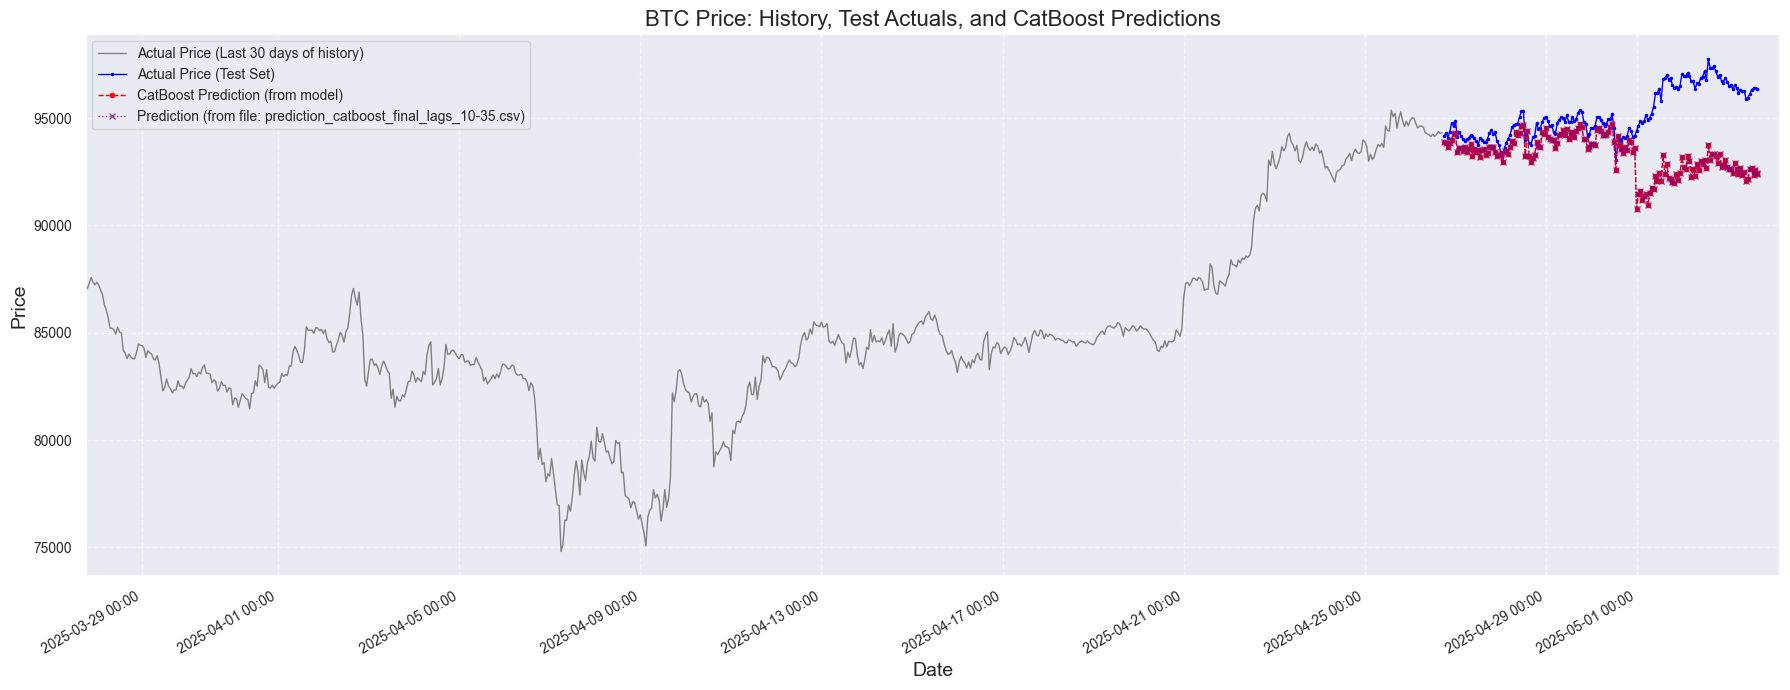

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Для форматирования дат на оси X

# --- Параметры и загрузка данных (убедись, что они актуальны) ---
TARGET = 'Price'
# Предполагаем, что 'data' - это полный DataFrame с исходными данными и DatetimeIndex
# 'y_test' - Series с фактическими значениями на тесте и DatetimeIndex
# 'final_predictions' - массив/Series предсказаний CatBoost на тесте

# Имя файла с предсказаниями CatBoost (сформированное ранее)
# Убедись, что lag_start_win и lag_end_win определены
if 'lag_start_win' not in locals() or 'lag_end_win' not in locals():
    print("Переменные lag_start_win и/или lag_end_win не определены. Использую значения по умолчанию (10, 35).")
    lag_start_win = 10 # Значение по умолчанию
    lag_end_win = 35   # Значение по умолчанию
    
catboost_prediction_filename = f'prediction_catboost_final_lags_{lag_start_win}-{lag_end_win}.csv'

# Загружаем предсказания из файла, если он существует
try:
    predictions_from_file_df = pd.read_csv(catboost_prediction_filename, index_col=0, parse_dates=True)
    # Убедимся, что индекс имеет правильную частоту, если это возможно (для консистентности с другими данными)
    if hasattr(predictions_from_file_df.index, 'asfreq') and hasattr(data.index, 'freq') and data.index.freq:
         try:
            predictions_from_file_df.index = predictions_from_file_df.index.asfreq(data.index.freq)
         except ValueError:
            print(f"Предупреждение: не удалось установить частоту {data.index.freq} для индекса файла {catboost_prediction_filename}")
    
    print(f"Предсказания из файла '{catboost_prediction_filename}' успешно загружены.")
    plot_file_predictions = True
except FileNotFoundError:
    print(f"Файл '{catboost_prediction_filename}' не найден. Предсказания из файла не будут отображены.")
    plot_file_predictions = False
except Exception as e:
    print(f"Ошибка при загрузке файла '{catboost_prediction_filename}': {e}")
    plot_file_predictions = False

# Убедимся, что y_test и final_predictions существуют
if 'y_test' not in locals() or not isinstance(y_test, pd.Series):
    print("Ошибка: y_test не определен или не является pd.Series. Невозможно построить график.")
    exit()
if 'final_predictions' not in locals() : # Проверяем только наличие, тип может быть np.array
    print("Ошибка: final_predictions не определены. Невозможно построить график.")
    exit()
if len(final_predictions) != len(y_test):
    print("Ошибка: Длины final_predictions и y_test не совпадают. Невозможно построить график.")
    exit()


# --- Определяем период для отображения ---
# Дата начала тестового периода
test_start_date = y_test.index.min()

# Дата начала для отображения исторических данных (например, 30 дней до начала теста)
history_display_days = 30
history_start_date = test_start_date - pd.Timedelta(days=history_display_days)

# Дата окончания тестового периода (для ограничения отображения)
test_end_date = y_test.index.max()

# Фильтруем исходные данные для отображения истории
history_data_to_plot = data[TARGET][(data.index >= history_start_date) & (data.index < test_start_date)]


# --- Построение графика ---
plt.figure(figsize=(18, 7))

# 1. Исторические данные (до тестового периода)
if not history_data_to_plot.empty:
    plt.plot(history_data_to_plot.index, history_data_to_plot.values, label=f'Actual Price (Last {history_display_days} days of history)', color='gray', linestyle='-')

# 2. Фактические данные на тестовом периоде
plt.plot(y_test.index, y_test.values, label='Actual Price (Test Set)', color='blue', linestyle='-', marker='.', markersize=3)

# 3. Предсказания CatBoost (из переменной final_predictions)
# Создаем Series с правильным индексом для удобства построения
catboost_predictions_series = pd.Series(final_predictions, index=y_test.index, name='CatBoost Live Prediction')
plt.plot(catboost_predictions_series.index, catboost_predictions_series.values, label='CatBoost Prediction (from model)', color='red', linestyle='--', marker='o', markersize=3)

# 4. Предсказания из файла (если загружены)
if plot_file_predictions:
    # Убедимся, что колонка с предсказаниями называется TARGET
    if TARGET in predictions_from_file_df.columns:
        plt.plot(predictions_from_file_df.index, predictions_from_file_df[TARGET], label=f'Prediction (from file: {catboost_prediction_filename})', color='purple', linestyle=':', marker='x', markersize=4, alpha=0.7)
    else:
        print(f"Предупреждение: Колонка '{TARGET}' не найдена в файле {catboost_prediction_filename}. Отображаю первую колонку.")
        plt.plot(predictions_from_file_df.index, predictions_from_file_df.iloc[:, 0], label=f'Prediction (from file, 1st col)', color='purple', linestyle=':', marker='x', markersize=4, alpha=0.7)


# Настройка графика
plt.title(f'BTC Price: History, Test Actuals, and CatBoost Predictions', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel(TARGET, fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

# Форматирование оси X для лучшей читаемости дат
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M')) # Формат даты и времени
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=12)) # Автоматический выбор количества меток
plt.xticks(rotation=30, ha='right')

# Ограничим диапазон оси X, чтобы график не был слишком растянут, если история очень длинная
# и чтобы четко видеть переход от истории к тесту
overall_plot_start_date = history_start_date
overall_plot_end_date = test_end_date + pd.Timedelta(hours=12) # небольшой запас после теста
plt.xlim([overall_plot_start_date, overall_plot_end_date])


plt.tight_layout()
plt.show()

## Рекурсивный прогноз

Последняя известная дата в данных: 2025-05-03 16:00:00
Прогнозируем на 168 часов вперед...
Размер X_train: (37962, 32), y_train: (37962,)
Размер X_test: (1, 32), y_test: (1,)
KeyError на шаге 1 рекурсивного прогноза: "Отсутствуют колонки в X_future_step ПОСЛЕ добавления Change %: {'avg_overall_sentiment', 'sum_news_count', 'avg_btc_specific_sentiment'}."
Размер X_train: (37962, 32), y_train: (37962,)
Размер X_test: (1, 32), y_test: (1,)
KeyError на шаге 2 рекурсивного прогноза: "Отсутствуют колонки в X_future_step ПОСЛЕ добавления Change %: {'avg_overall_sentiment', 'sum_news_count', 'avg_btc_specific_sentiment'}."
Размер X_train: (37963, 32), y_train: (37963,)
Размер X_test: (1, 32), y_test: (1,)
KeyError на шаге 3 рекурсивного прогноза: "Отсутствуют колонки в X_future_step ПОСЛЕ добавления Change %: {'avg_overall_sentiment', 'sum_news_count', 'avg_btc_specific_sentiment'}."
Размер X_train: (37964, 32), y_train: (37964,)
Размер X_test: (1, 32), y_test: (1,)
KeyError на шаге 4 рекурсив

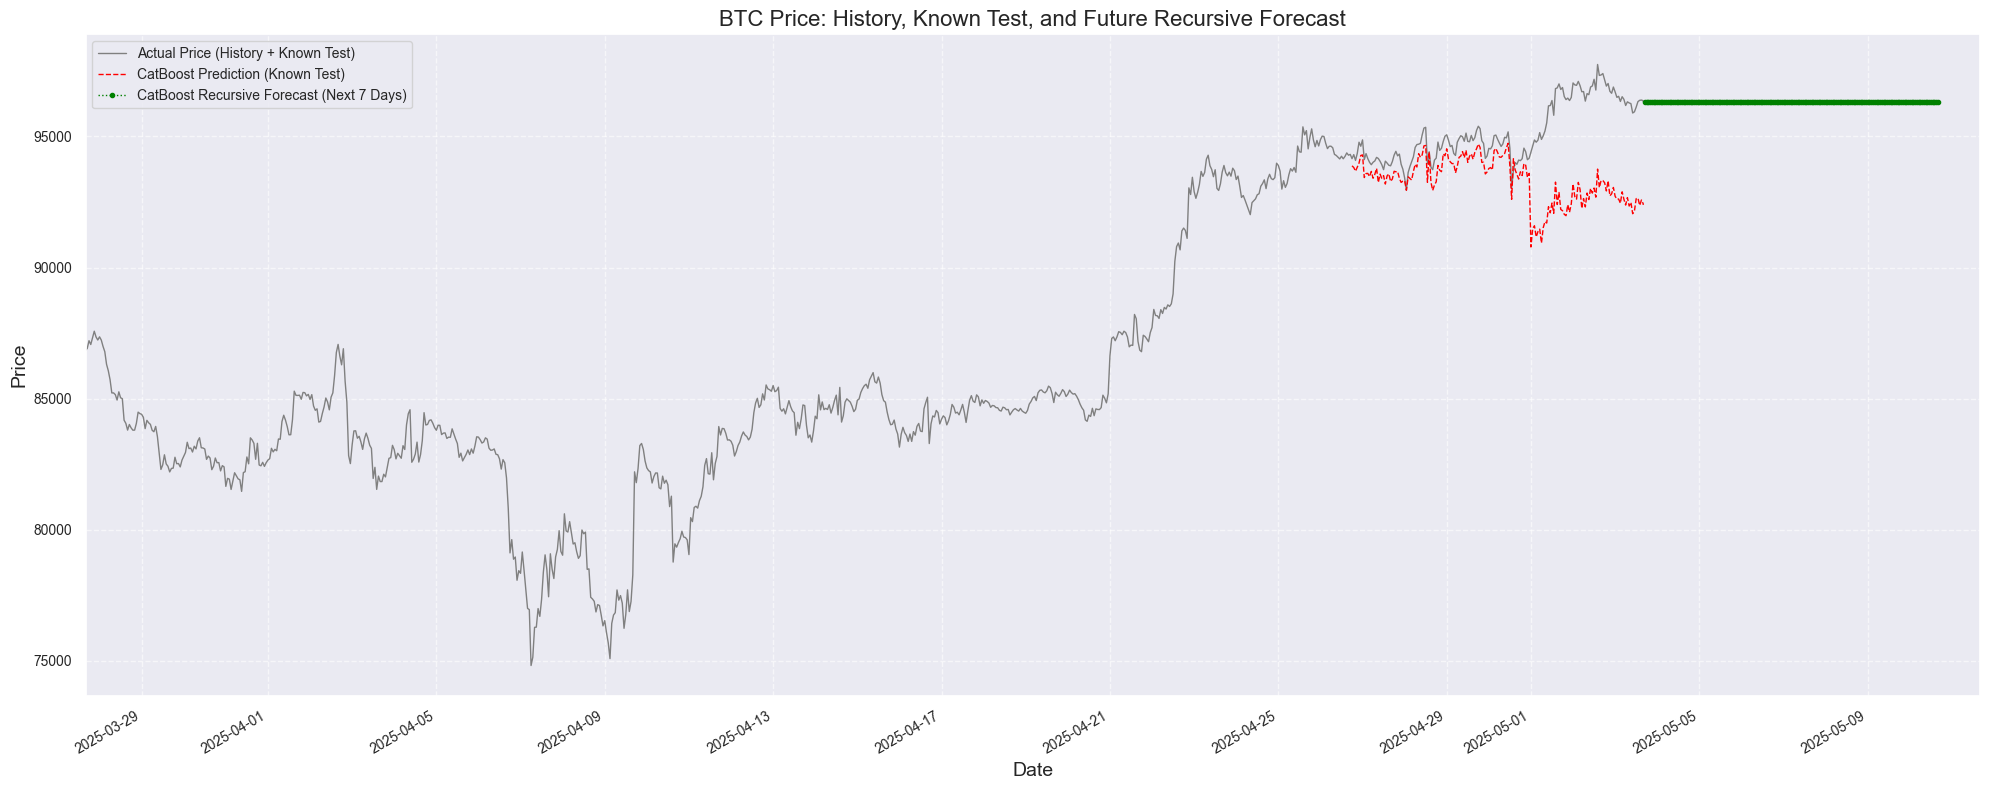

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Предположения и параметры ---
# ... (все переменные как раньше) ...

# Убедимся, что все нужные переменные существуют
required_vars = ['TARGET', 'model_for_opt', 'X_train', 'y_test', 'final_predictions',
                 'lag_start_win', 'lag_end_win', 'generate_lags', 
                 'preprocess_data_hourly_no_leak', 'data']
for var_name in required_vars:
    if var_name not in locals():
        print(f"Ошибка: Переменная '{var_name}' не определена. Невозможно продолжить.")
        exit()

future_forecast_horizon_hours = 24 * 7
last_known_datetime = data.index[-1]

print(f"Последняя известная дата в данных: {last_known_datetime}")
print(f"Прогнозируем на {future_forecast_horizon_hours} часов вперед...")

future_recursive_preds_list = []
future_datetimes_list = []

rolling_data_df = data.copy() 
base_cols_to_fill = ['Open', 'High', 'Low']
for col in base_cols_to_fill:
    if col not in rolling_data_df.columns:
        rolling_data_df[col] = rolling_data_df[TARGET]

# --- Рекурсивное прогнозирование ---
current_future_datetime = last_known_datetime
for i in range(future_forecast_horizon_hours):
    current_future_datetime += pd.Timedelta(hours=1)
    future_datetimes_list.append(current_future_datetime)
    
    prev_target_val_for_ohl = rolling_data_df[TARGET].iloc[-1] # Цена предыдущего шага для OHL
    
    future_row_data = {col: prev_target_val_for_ohl for col in base_cols_to_fill}
    future_row_data[TARGET] = 0 # Фиктивное значение для TARGET
    future_row_df = pd.DataFrame(future_row_data, index=[current_future_datetime])
    temp_df_for_preprocess = pd.concat([rolling_data_df[base_cols_to_fill + [TARGET]], future_row_df])
    
    predicted_value = np.nan # Инициализируем на случай ошибки

    try:
        _, X_future_step, _, y_future_step_dummy = preprocess_data_hourly_no_leak( # y_future_step_dummy не используется
            data_input=temp_df_for_preprocess,
            target_col_name=TARGET,
            lags_to_create=generate_lags(lag_start_win, lag_end_win),
            test_size_hours=1
        )

        if X_future_step.empty:
            print(f"Шаг {i+1}: X_future_step пуст. Используем предыдущий прогноз или значение OHL.")
            predicted_value = future_recursive_preds_list[-1] if future_recursive_preds_list else prev_target_val_for_ohl
        else:
            # --- НАЧАЛО ИЗМЕНЕНИЙ ДЛЯ Change % ---
            # Рассчитываем 'Change %' для X_future_step
            # 'Change %' - это (текущая цена - предыдущая цена) / предыдущая цена * 100
            # "Текущая цена" для расчета Change % здесь будет prev_target_val_for_ohl,
            # так как X_future_step формируется ДО того, как мы узнаем `predicted_value`
            # Цена еще более предыдущего шага (для знаменателя)
            if len(rolling_data_df[TARGET]) >= 2:
                price_t_minus_1 = prev_target_val_for_ohl # Это цена в T (для X_future_step в T+1)
                price_t_minus_2 = rolling_data_df[TARGET].iloc[-2] # Это цена в T-1
                if price_t_minus_2 != 0: # Избегаем деления на ноль
                    change_percent = ((price_t_minus_1 - price_t_minus_2) / price_t_minus_2) * 100
                else:
                    change_percent = 0.0 # или np.nan
            else: # Для самого первого шага или если истории мало
                change_percent = 0.0 # или np.nan
            
            # Добавляем рассчитанный 'Change %' в X_future_step
            # Важно: X_future_step это DataFrame, присваиваем значение для его единственной строки
            X_future_step.loc[X_future_step.index[0], 'Change %'] = change_percent
            # --- КОНЕЦ ИЗМЕНЕНИЙ ДЛЯ Change % ---

            missing_cols = set(X_train.columns) - set(X_future_step.columns)
            if missing_cols:
                 # Если после добавления Change % все еще чего-то не хватает (не должно быть)
                raise KeyError(f"Отсутствуют колонки в X_future_step ПОСЛЕ добавления Change %: {missing_cols}.")
            
            X_future_step_aligned = X_future_step[X_train.columns]
            predicted_value = model_for_opt.predict(X_future_step_aligned)[0]
            
    except KeyError as ke:
        print(f"KeyError на шаге {i+1} рекурсивного прогноза: {ke}")
        # ... (остальная обработка KeyError) ...
        predicted_value = future_recursive_preds_list[-1] if future_recursive_preds_list else prev_target_val_for_ohl
    except Exception as e_pred_step:
        print(f"Общая ошибка на шаге {i+1} рекурсивного прогноза: {e_pred_step}")
        # ... (остальная обработка Exception) ...
        predicted_value = future_recursive_preds_list[-1] if future_recursive_preds_list else prev_target_val_for_ohl

    future_recursive_preds_list.append(predicted_value)
    
    new_ohlc_row_data = {col: predicted_value for col in base_cols_to_fill}
    new_ohlc_row_data[TARGET] = predicted_value
    # 'Change %' для rolling_data_df (если мы его там храним) тоже нужно обновить
    # Это будет ((predicted_value - prev_target_val_for_ohl) / prev_target_val_for_ohl) * 100
    if prev_target_val_for_ohl != 0:
        current_change_percent_for_storage = ((predicted_value - prev_target_val_for_ohl) / prev_target_val_for_ohl) * 100
    else:
        current_change_percent_for_storage = 0.0
    
    if 'Change %' in rolling_data_df.columns: # Если мы вообще храним Change % в rolling_data_df
        new_ohlc_row_data['Change %'] = current_change_percent_for_storage
    
    new_ohlc_row_df = pd.DataFrame(new_ohlc_row_data, index=[current_future_datetime])
    rolling_data_df = pd.concat([rolling_data_df, new_ohlc_row_df])
    rolling_data_df = rolling_data_df[~rolling_data_df.index.duplicated(keep='last')]

    if (i + 1) % 24 == 0:
        print(f"  Рекурсивный прогноз: шаг {i+1}/{future_forecast_horizon_hours} завершен. Предсказано: {predicted_value:.2f}")

future_recursive_predictions_series = pd.Series(future_recursive_preds_list, index=pd.DatetimeIndex(future_datetimes_list), name='CatBoost Recursive Future Forecast')

# --- Визуализация (код остается тем же) ---
# ... (код визуализации как в предыдущем ответе) ...
plt.figure(figsize=(20, 8))
history_plus_test_end_date = y_test.index.max() if 'y_test' in locals() and not y_test.empty else data.index.max()
history_plus_test_start_date = history_plus_test_end_date - pd.Timedelta(days=30 + 7)
data_to_plot_history = data[TARGET][(data.index >= history_plus_test_start_date) & (data.index <= history_plus_test_end_date)]
if not data_to_plot_history.empty:
    plt.plot(data_to_plot_history.index, data_to_plot_history.values, label=f'Actual Price (History + Known Test)', color='gray', linestyle='-')
if 'final_predictions' in locals() and 'y_test' in locals() and not y_test.empty and len(final_predictions) == len(y_test):
    known_test_predictions_series = pd.Series(final_predictions, index=y_test.index)
    plt.plot(known_test_predictions_series.index, known_test_predictions_series.values, label='CatBoost Prediction (Known Test)', color='red', linestyle='--')
if not future_recursive_predictions_series.empty:
    plt.plot(future_recursive_predictions_series.index, future_recursive_predictions_series.values, label=f'CatBoost Recursive Forecast (Next {future_forecast_horizon_hours/24:.0f} Days)', color='green', linestyle=':', marker='.')
plt.title(f'BTC Price: History, Known Test, and Future Recursive Forecast', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel(TARGET, fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=15))
plt.xticks(rotation=30, ha='right')
plot_overall_start = history_plus_test_start_date
plot_overall_end = future_recursive_predictions_series.index.max() + pd.Timedelta(days=1) if not future_recursive_predictions_series.empty else history_plus_test_end_date + pd.Timedelta(days=1)
plt.xlim([plot_overall_start, plot_overall_end])
plt.tight_layout()
plt.show()